<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Pregunta 2 - Autoencoders </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Autoencoders tradicionales y sus aplicaciones.

<hr style="height:2px;border:none"/>

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

In [1]:
import math
import time

from keras import activations
from keras.datasets import mnist
from keras import layers
from keras import losses
from keras import models
from keras import optimizers
from keras import utils
from matplotlib import pyplot
import numpy as np
from numpy.random import binomial
import pandas as pd
from sklearn import decomposition
from sklearn import manifold
from sklearn import model_selection
from sklearn import neighbors

Using TensorFlow backend.


> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

Primero leemos los datos y construimos los datos de entrenamiento, validación y pruebas. Los dejaremos normalizados entre 0 y 1, dividiendo por la intensidad máxima (255). El conjunto de pruebas tiene 10 mil imágenes, el de entrenamiento 55 mil y el de validación, 5 mil.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train, y_train, test_size=0.08333)
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('Tamaño x_train:', x_train.shape)
print('Tamaño x_val:', x_val.shape)
print('Tamaño x_test:', x_test.shape)

Tamaño x_train: (55000, 28, 28)
Tamaño x_val: (5000, 28, 28)
Tamaño x_test: (10000, 28, 28)


### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

In [3]:
x_train1 = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val1 = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
x_test1  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('Tamaño x_train:', x_train1.shape)
print('Tamaño x_val:', x_val1.shape)
print('Tamaño x_test:', x_test1.shape)

Tamaño x_train: (55000, 784)
Tamaño x_val: (5000, 784)
Tamaño x_test: (10000, 784)


Contamos ahora con los conjuntos como matrices, de tamaño cantidad de imágenes $\times$ vector de 784 características.

Una de las aplicaciones típicas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

Haremos una función auxiliar para definir el modelo, con opciones que irán cambiando en las siguientes preguntas para experimentar distintos tipos de arquitectura de Autoencoder (capas densas o convolucionales, cantidad de capas ocultas, optimizador, etc.). En todas las versiones, usaremos la función de pérdida binary_crossentropy. Es decir, estamos suponiendo que un pixel de la imágen tiene una probabilidad de estar encendido o no. Si está encendido, tiene un 1, y si está apagado, un 0. Esta suposición no es del todo cierta, ya que la imágen puede tener matices, y la función de pérdida será asimétrica, forzando a que tal vez los valores obtenidos en la reconstrucción sean más cercanos a 0.5 que a los extremos.

In [4]:
num_epochs = 200

def activation_name(activation):
    """Get correct activation name."""
    if activation is None:
        return activations.sigmoid.__name__
    return activation.__name__

def build_model(local_x_train, local_x_val, encod_dim,
                hidden_layers=0, hidden_num=1000, optimizer=None,
                extra_x_train=None, extra_x_val=None,
                encoder_activation=None):
    x_shape = local_x_train.shape[1:]
    use_convolutional = len(x_shape) > 1
    encoder_activation = (activations.sigmoid
                          if encoder_activation is None else
                          encoder_activation)
    input_img = layers.Input(shape=x_shape)
    encoded = input_img
    current_size = x_shape[0]
    for num_layer in range(hidden_layers):
        if use_convolutional:
            encoded = layers.Conv2D(
                int(hidden_num / (2 ** num_layer)), (3, 3),
                activation=activations.relu, padding='same')(encoded)
            encoded = layers.MaxPooling2D((2, 2), padding='same')(encoded)
            current_size = math.ceil(float(current_size) / 2)
        else:
            encoded = layers.Dense(int(hidden_num / (2 ** num_layer)),
                                   activation=activations.relu)(encoded)
    if not use_convolutional:
        encoded = layers.Dense(encod_dim,
                               activation=encoder_activation)(encoded)
    decoded = encoded
    total_decoder_layers = 0
    for num_layer in range(hidden_layers):
        if use_convolutional:
            decoded = layers.Conv2DTranspose(
                int(encod_dim / (2 ** (hidden_layers - num_layer - 2))), (3, 3),
                activation=activations.relu, padding='same')(decoded)
            decoded = layers.UpSampling2D((2, 2))(decoded)
            total_decoder_layers += 2
        else:
            decoded = layers.Dense(
                int(hidden_num / (2 ** (hidden_layers - num_layer - 1))),
                activation=activations.relu)(decoded)
            total_decoder_layers += 1
    if use_convolutional:
        decoded = layers.Conv2DTranspose(
            1, (3, 3), activation=activations.sigmoid, padding='same')(decoded)
        cropping = int((current_size * (2 ** hidden_layers) - x_shape[0]) / 2)
        decoded = layers.Cropping2D(cropping=cropping)(decoded)
        total_decoder_layers += 2
    else:
        decoded = layers.Dense(x_shape[0],
                               activation=activations.sigmoid)(decoded)
        total_decoder_layers += 1
    autoencoder = models.Model(inputs=input_img, outputs=decoded)
    encoder = models.Model(inputs=input_img, outputs=encoded)
    if use_convolutional:
        encoded_input = layers.Input(shape=(
            current_size, current_size,
            int(hidden_num / (2 ** (hidden_layers - 1)))))
    else:
        encoded_input = layers.Input(shape=(encod_dim,))
    decoder_output = encoded_input
    for layer_num in range(-total_decoder_layers, 0):
        decoder_output = autoencoder.layers[layer_num](decoder_output)
    decoder = models.Model(inputs=encoded_input, outputs=decoder_output)
    optimizer = optimizers.SGD(lr=1.0) if optimizer is None else optimizer
    # binary crossentropy por pixel
    autoencoder.compile(optimizer=optimizer, loss=losses.binary_crossentropy)
    print('Autoencoder dim', encod_dim, 'hidden layers', hidden_layers,
          'hidden num', hidden_num, 'convolutional', use_convolutional)
    print(autoencoder.summary())
    if extra_x_train is None:
        extra_x_train = local_x_train
    if extra_x_val is None:
        extra_x_val = local_x_val
    hist = autoencoder.fit(local_x_train, extra_x_train, epochs=num_epochs,
                           batch_size=32, verbose=0,
                           validation_data=(local_x_val, extra_x_val))
    _ = pd.DataFrame(hist.history).iloc[2:, :].plot(title=(
        'Autoencoder dim {} hidden layers {} ({}) convolutional {}'.format(encod_dim, hidden_layers, hidden_num, use_convolutional)))
    pyplot.show()
    print('Error train:', hist.history['loss'][-1],
          'Error val:', hist.history['val_loss'][-1])
    name = '{}_{}_{}_{}_{}'.format(
        encod_dim, x_shape[0], hidden_layers, int(hidden_num),
        activation_name(encoder_activation))
    encoder.save('basic_encoder_{}.h5'.format(name))
    decoder.save('basic_decoder_{}.h5'.format(name))
    autoencoder.save('basic_autoencoder_{}.h5'.format(name))
    return hist

def load_autoencoder(input_size, encod_dim, hidden_layers=0,
                     hidden_num=1000, encoder_activation=None):
    name = '{}_{}_{}_{}_{}'.format(
        encod_dim, input_size, hidden_layers, hidden_num,
        activation_name(encoder_activation))
    encoder = models.load_model('basic_encoder_{}.h5'.format(name))
    decoder = models.load_model('basic_decoder_{}.h5'.format(name))
    autoencoder = models.load_model('basic_autoencoder_{}.h5'.format(name))
    return encoder, decoder, autoencoder

Probamos entonces diferentes valores para el tamaño de la codificación obtenida por la red.

Autoencoder dim 2 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None


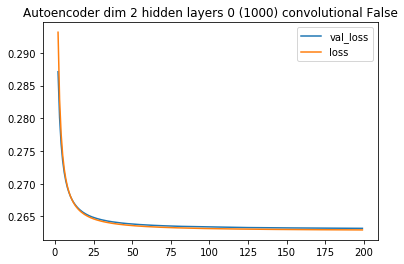

Error train: 0.2629363415371288 Error val: 0.2631764893054962
Autoencoder dim 4 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               3920      
Total params: 7,060
Trainable params: 7,060
Non-trainable params: 0
_________________________________________________________________
None


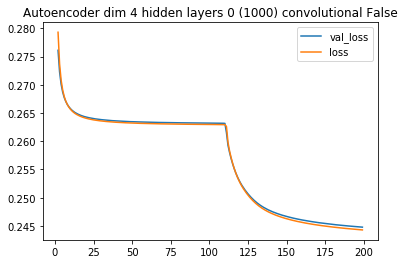

Error train: 0.244289818592505 Error val: 0.24477950448989869
Autoencoder dim 8 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 6280      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               7056      
Total params: 13,336
Trainable params: 13,336
Non-trainable params: 0
_________________________________________________________________
None


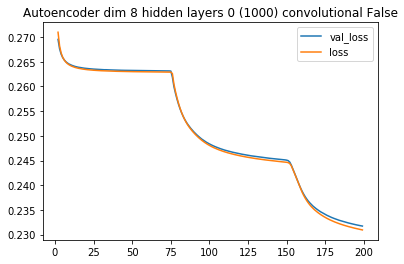

Error train: 0.2309472194216468 Error val: 0.2317274357318878
Autoencoder dim 16 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________
None


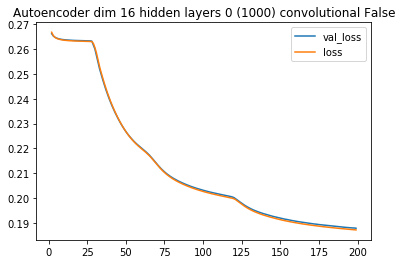

Error train: 0.18727147076563402 Error val: 0.187944189119339
Autoencoder dim 32 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_10 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


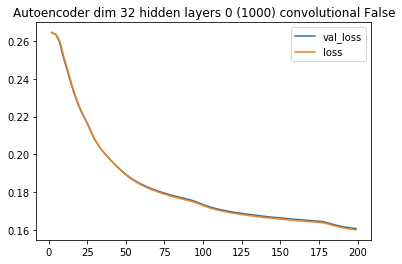

Error train: 0.16001389321847395 Error val: 0.16070750169754028
Autoencoder dim 64 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_12 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
None


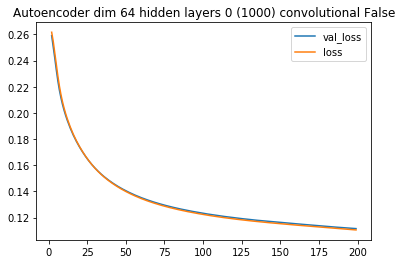

Error train: 0.11051954307122663 Error val: 0.11151371388435363
Autoencoder dim 128 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None


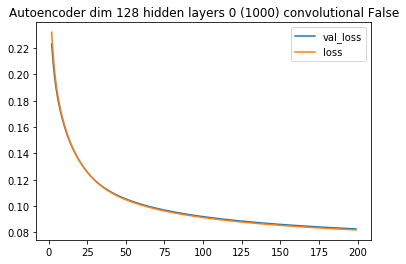

Error train: 0.0819319125533104 Error val: 0.0826861095070839
Autoencoder dim 256 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_16 (Dense)             (None, 784)               201488    
Total params: 402,448
Trainable params: 402,448
Non-trainable params: 0
_________________________________________________________________
None


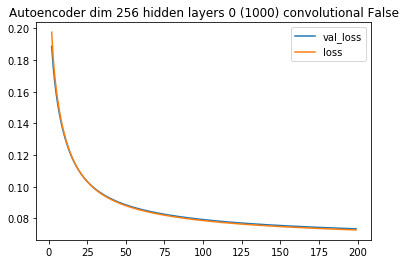

Error train: 0.07276920259540731 Error val: 0.07345930302143097
Autoencoder dim 512 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_18 (Dense)             (None, 784)               402192    
Total params: 804,112
Trainable params: 804,112
Non-trainable params: 0
_________________________________________________________________
None


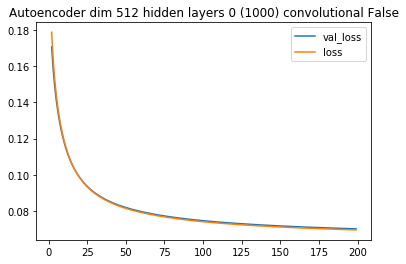

Error train: 0.06964796643257141 Error val: 0.07023865057229996


In [5]:
encod_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512]
train_errors = []
val_errors = []
for encod_dim in encod_sizes:
    hist = build_model(x_train1, x_val1, encod_dim)
    train_errors.append(hist.history['loss'][-1])
    val_errors.append(hist.history['val_loss'][-1])

A través de los gráficos de error de entrenamiento y validación versus los epochs de entrenamiento, vemos que el algoritmo de gradiente descendiente estocástico da "saltos" donde hay una disminución significativa del error de reconstrucción. Esto significa que le cuesta encontrar los patrones a incluir en la codificación, pero que una vez que los encuentra, los asimila bien y continua la optimización hasta el siguiente "salto". Es interesante que pese a la gran cantidad de epochs que experimentamos (200), no logramos sobreajustar la red, includo en el caso de encoder de tamaño 512, donde ya la cantidad de parámetros es altísima (402 mil en el encoder).

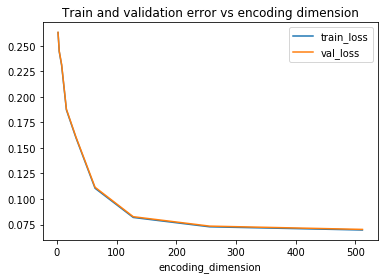

In [6]:
to_plot = pd.DataFrame(data={'encoding_dimension': encod_sizes,
                             'train_loss': train_errors,
                             'val_loss': val_errors})
to_plot.plot(x='encoding_dimension', y=['train_loss', 'val_loss'],
             title='Train and validation error vs encoding dimension')
pyplot.show()

Obviamente, mientras más grande es la dimensión de la foto codificada, menor es el error de reconstrucción, pues la red neuronal puede aprender a reconstruir los datos con más información. Intuitivamente, esperábamos que no sirviera guardar toda la imagen, pues entonces sobreajustaría y el error de generalización (que medimos a través del conjunto de validación), aumentaría. Esto no lo observamos en la experimentación, por lo que tal vez la red está aprendiendo una representación grande pero que extrae características útiles para la generalización.

Con respecto a la función de activación, la gracia de usar sigmoide en la activación del encoder permite que la imagen codificada (o espacio latente), tenga el mismo rango que la entrada y salida, esto es, entre 0 y 1. De todas maneras, probaremos cómo se comporta el autoencoder usando una activación ReLU en el encoder.

Autoencoder dim 2 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_20 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
None


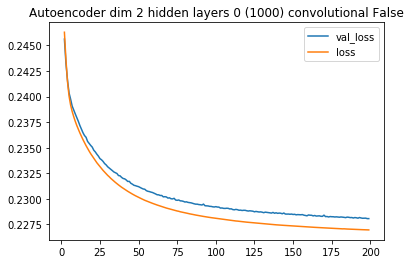

Error train: 0.22695854186144743 Error val: 0.2280639406681061
Autoencoder dim 4 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 3140      
_________________________________________________________________
dense_22 (Dense)             (None, 784)               3920      
Total params: 7,060
Trainable params: 7,060
Non-trainable params: 0
_________________________________________________________________
None


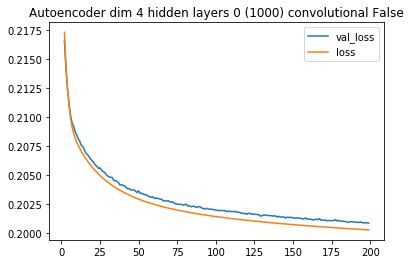

Error train: 0.20025628997629338 Error val: 0.20084435710906984
Autoencoder dim 8 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 6280      
_________________________________________________________________
dense_24 (Dense)             (None, 784)               7056      
Total params: 13,336
Trainable params: 13,336
Non-trainable params: 0
_________________________________________________________________
None


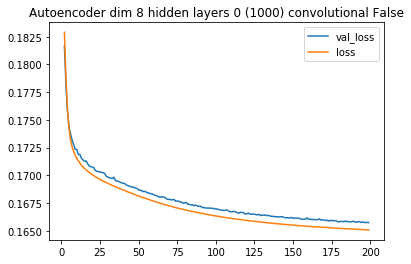

Error train: 0.16507655925533987 Error val: 0.16574101243019104
Autoencoder dim 16 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_26 (Dense)             (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________
None


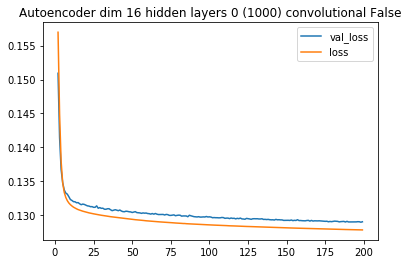

Error train: 0.12783994955908168 Error val: 0.12903925273418426
Autoencoder dim 32 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_28 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
None


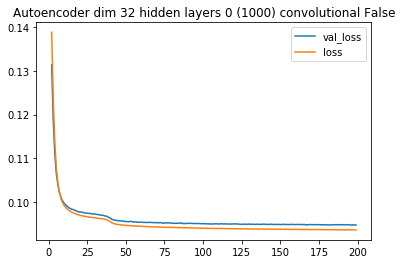

Error train: 0.09369698477549987 Error val: 0.09481932599544525
Autoencoder dim 64 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_30 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________
None


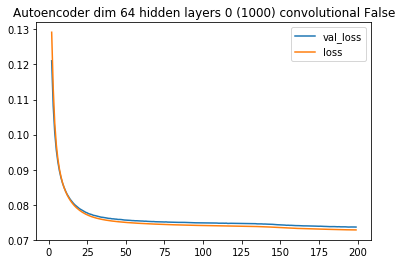

Error train: 0.0728629508506168 Error val: 0.07367831381559371
Autoencoder dim 128 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_32 (Dense)             (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None


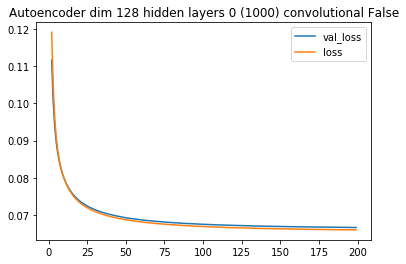

Error train: 0.06599369886896828 Error val: 0.0666398298382759
Autoencoder dim 256 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_34 (Dense)             (None, 784)               201488    
Total params: 402,448
Trainable params: 402,448
Non-trainable params: 0
_________________________________________________________________
None


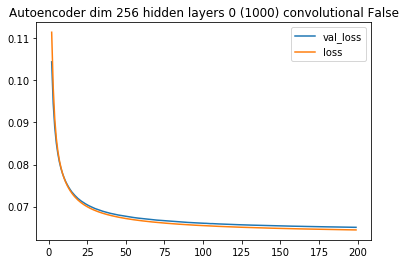

Error train: 0.06445072990439155 Error val: 0.06506699634790421
Autoencoder dim 512 hidden layers 0 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_36 (Dense)             (None, 784)               402192    
Total params: 804,112
Trainable params: 804,112
Non-trainable params: 0
_________________________________________________________________
None


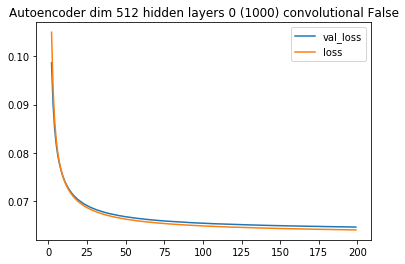

Error train: 0.06397091119614515 Error val: 0.06456692492961884


In [7]:
train_errors_relu = []
val_errors_relu = []
for encod_dim in encod_sizes:
    hist = build_model(x_train1, x_val1, encod_dim,
                       encoder_activation=activations.relu)
    train_errors_relu.append(hist.history['loss'][-1])
    val_errors_relu.append(hist.history['val_loss'][-1])

Vemos que el entrenamiento en este caso ya no da saltos grandes, sino que continuamente va bajando el error de entrenamiento y validación. Esto significa que, para el algoritmo de gradiente descendiente estocástico, es más fácil aprender cuando la función de activación es ReLU.

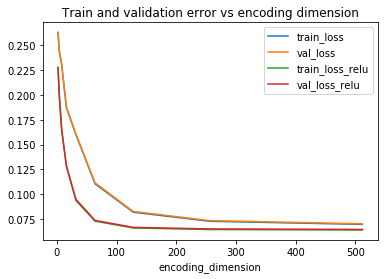

In [8]:
to_plot = pd.DataFrame(data={'encoding_dimension': encod_sizes,
                             'train_loss': train_errors,
                             'val_loss': val_errors,
                             'train_loss_relu': train_errors_relu,
                             'val_loss_relu': val_errors_relu})
to_plot.plot(x='encoding_dimension',
             y=['train_loss', 'val_loss', 'train_loss_relu', 'val_loss_relu'],
             title='Train and validation error vs encoding dimension')
pyplot.show()

En este último gráfico podemos ver que, para todos los tamaños de codificación, el error de validación obtenido de reconstrucción resulta menor para la función de activación ReLU. Una razón de esto puede ser que la activación en la codificación es *sparse*, permitiendo que algunas características del espacio latente se desactiven. Por otro lado, el uso de la función ReLU permite que el aprendizaje no se estanque en regiones de saturación, como sí sucede con sigmoide. A partir de este resultado, usaremos ReLU como activación en todos los experimentos posteriores.

> b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

In [9]:
def visualize_encoder(local_x_test, encod_dim, hidden_layers=0,
                      hidden_num=1000, encoder_activation=None):
    print('Codificación tamaño', encod_dim)
    encoder, decoder, autoencoder = load_autoencoder(
        local_x_test.shape[1], encod_dim, hidden_layers=hidden_layers,
        hidden_num=hidden_num, encoder_activation=encoder_activation)
    encoded_test = encoder.predict(local_x_test)
    decoded_test = decoder.predict(encoded_test)
    n = 10
    pyplot.figure(figsize=(20, 4))
    for i in range(n):
        j = np.random.randint(0, len(local_x_test))
        ax = pyplot.subplot(2, n, i + 1)
        pyplot.imshow(local_x_test[j].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = pyplot.subplot(2, n, i + 1 + n)
        pyplot.imshow(decoded_test[j].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    pyplot.show()

Codificación tamaño 2


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


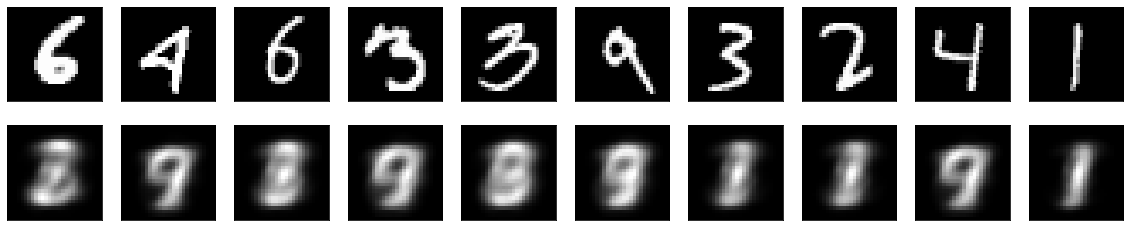

Codificación tamaño 4


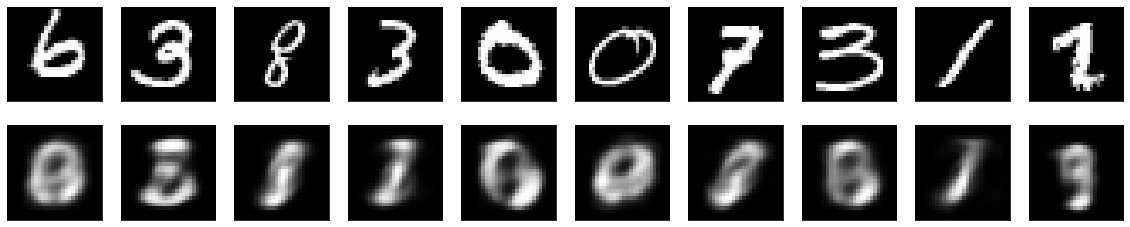

Codificación tamaño 8


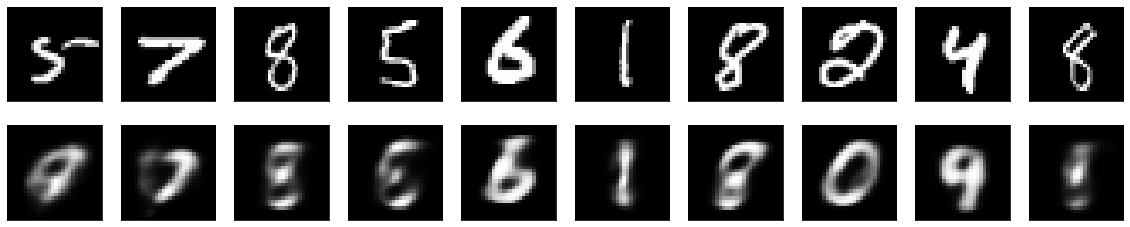

Codificación tamaño 16


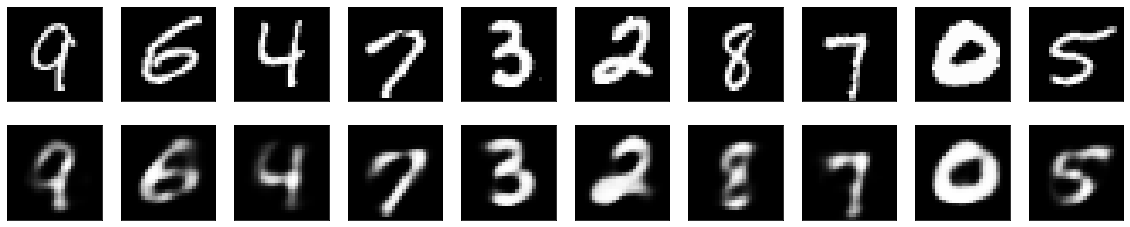

Codificación tamaño 32


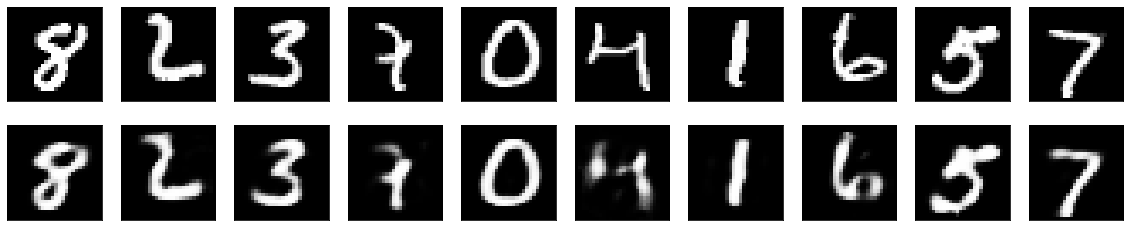

Codificación tamaño 64


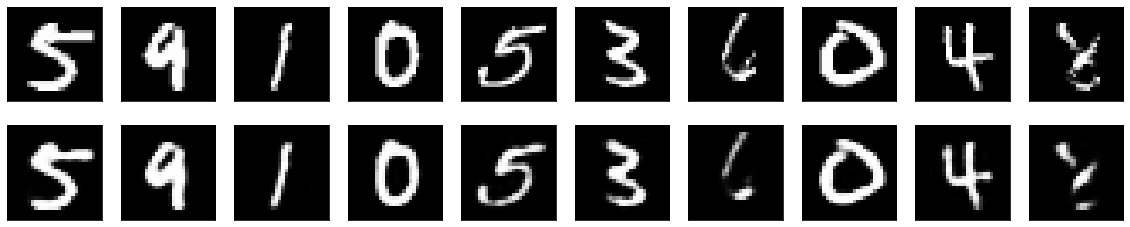

Codificación tamaño 128


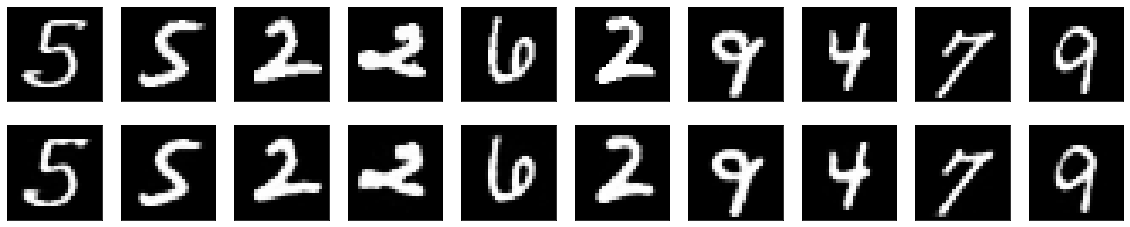

Codificación tamaño 256


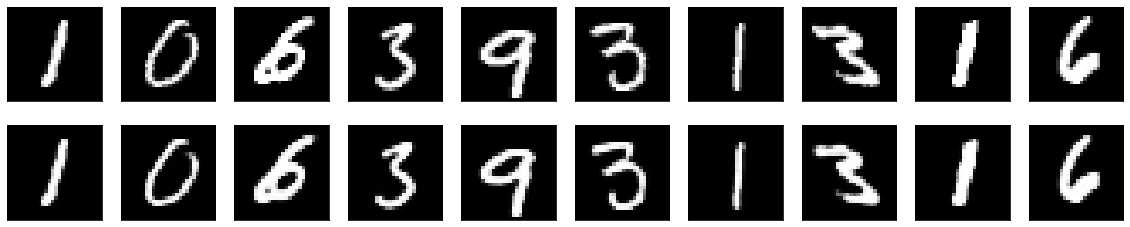

Codificación tamaño 512


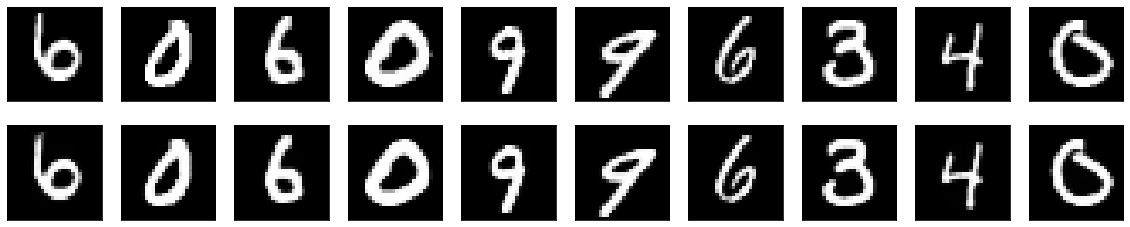

In [10]:
for encod_dim in encod_sizes:
    visualize_encoder(x_test1, encod_dim,
                      encoder_activation=activations.relu)

En la visualización de reconstrucción para imágenes aleatorias, vemos que efectivamente, cuanto mayor es el tamaño de la codificación, mejor es la reconstrucción. Esto es acorde a que el error de reconstrucción de validación disminuye. Podemos observar que incluso en el caso de tamaño 512, la reconstrucción no es perfecta. Esto significa que una pequeña parte de la información de la imagen original se pierde al reducir la dimensionalidad. Visualmente, vemos que recién con tamaño 16 las imágenes empiezan a tener más sentido, y sería posible distinguir los dígitos. Con tamaño 32, ya la reconstrucción es suficientemente clara como para clasificar visualmente sin problemas.

> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación, además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [11]:
def compare_pca_autoencoder(local_x_train, local_y_train,
                            local_x_test, local_y_test,
                            encod_dim, hidden_layers=0, hidden_num=1000,
                            encoder_activation=None):
    # CLASIFICATION
    pca = decomposition.PCA(n_components=encod_dim)
    pca_x_train = local_x_train
    pca_x_test = local_x_test
    if len(pca_x_train.shape) > 2:
        pca_x_train = pca_x_train.reshape((
            pca_x_train.shape[0],
            pca_x_train.shape[1] * pca_x_train.shape[2] * pca_x_train.shape[3]))
        pca_x_test = pca_x_test.reshape((
            pca_x_test.shape[0],
            pca_x_test.shape[1] * pca_x_test.shape[2] * pca_x_test.shape[3]))
    pca.fit(pca_x_train)
    pca_train = pca.transform(pca_x_train)
    clf = neighbors.KNeighborsClassifier(10)
    clf.fit(pca_train, local_y_train)
    pca_time = time.time()
    pca_test = pca.transform(pca_x_test)
    pca_score = clf.score(pca_test, local_y_test)
    pca_time = time.time() - pca_time
    print('Classification Accuracy dim {} PCA {:.2f}'.format(
        encod_dim, pca_score))
    # AUTOENCODER
    encoder, decoder, autoencoder = load_autoencoder(
        local_x_test.shape[1], encod_dim, hidden_layers=hidden_layers,
        hidden_num=hidden_num, encoder_activation=encoder_activation)
    encoded_train = encoder.predict(local_x_train)
    if len(encoded_train.shape) > 2:
        encoded_train = encoded_train.reshape((
            encoded_train.shape[0],
            encoded_train.shape[1] * encoded_train.shape[2] *
            encoded_train.shape[3]))
    clf = neighbors.KNeighborsClassifier(10)
    clf.fit(encoded_train, local_y_train)
    encoder_time = time.time()
    encoded_test = encoder.predict(local_x_test)
    if len(encoded_test.shape) > 2:
        encoded_test = encoded_test.reshape((
            encoded_test.shape[0],
            encoded_test.shape[1] * encoded_test.shape[2] *
            encoded_test.shape[3]))
    encoder_score = clf.score(encoded_test, local_y_test)
    encoder_time = time.time() - encoder_time
    print('Classification Accuracy Autoencoder dim {} {:.2f}'.format(
        encod_dim, encoder_score))
    return (pca, pca_train, pca_test, pca_score, encoder_score, pca_time,
            encoder_time)

A continuación, mediremos el error de clasificación usando PCA y Autoencoder de diferentes tamaños, y medimos el tiempo de ejecución para realizar la reducción de dimensionalidad.

In [12]:
pca_scores = []
ae_scores = []
pca_times = []
ae_times = []
for encod_dim in encod_sizes:
    pca, pca_train, pca_test, pca_score, ae_score, pca_time, ae_time = compare_pca_autoencoder(
        x_train1, y_train, x_test1, y_test, encod_dim, encoder_activation=activations.relu)
    pca_scores.append(pca_score)
    ae_scores.append(ae_score)
    pca_times.append(pca_time)
    ae_times.append(ae_time)

Classification Accuracy dim 2 PCA 0.44


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 2 0.45
Classification Accuracy dim 4 PCA 0.65


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 4 0.66
Classification Accuracy dim 8 PCA 0.90


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 8 0.90
Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.95
Classification Accuracy dim 32 PCA 0.97


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 32 0.97
Classification Accuracy dim 64 PCA 0.97


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 64 0.96
Classification Accuracy dim 128 PCA 0.97


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 128 0.96
Classification Accuracy dim 256 PCA 0.97


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 256 0.96
Classification Accuracy dim 512 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 512 0.96


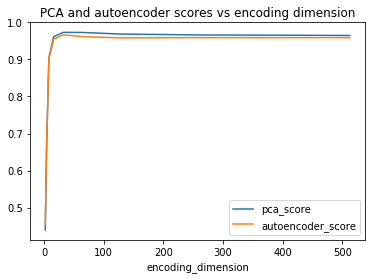

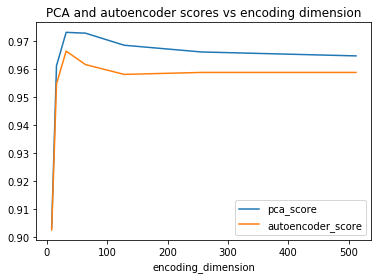

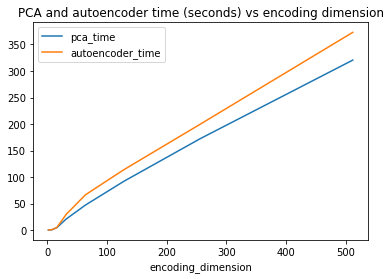

In [13]:
to_plot = pd.DataFrame(data={'encoding_dimension': encod_sizes,
                             'pca_score': pca_scores,
                             'autoencoder_score': ae_scores,
                             'pca_time': pca_times,
                             'autoencoder_time': ae_times})
to_plot.plot(x='encoding_dimension', y=['pca_score', 'autoencoder_score'],
             title='PCA and autoencoder scores vs encoding dimension')
pyplot.show()
to_plot2 = pd.DataFrame(data={'encoding_dimension': encod_sizes[2:],
                              'pca_score': pca_scores[2:],
                              'autoencoder_score': ae_scores[2:],
                              'pca_time': pca_times[2:],
                              'autoencoder_time': ae_times[2:]})
to_plot2.plot(x='encoding_dimension', y=['pca_score', 'autoencoder_score'],
              title='PCA and autoencoder scores vs encoding dimension')
pyplot.show()
to_plot.plot(x='encoding_dimension', y=['pca_time', 'autoencoder_time'],
             title='PCA and autoencoder time (seconds) vs encoding dimension')
pyplot.show()

A partir de los últimos gráficos vemos que en general PCA presenta un score mayor de generalización, para la misma cantidad de dimensiones reducidas. Es decir, es más conveniente utilizar PCA, especialmente para dimensiones pequeñas, para una tarea de clasificación. En cuanto al tiempo de predicción, vemos que, **una vez ya entrenados**, PCA demora menos en realizar la transformación al espacio de dimensión reducida, especialmente para una cantidad de dimensiones alta.

Al preguntarnos por qué esto ocurre, PCA está eligiendo las proyecciones que maximizan la varianza entre los datos, naturalmente separando los números, mientras que el autoencoder, como fue entrenado para reconstruir los números, tal vez busca características de la forma del número que permitan reconstruirlo, y no necesariamente que los separen. Habría que revisar otras funciones de activación o funciones de error para ver cómo se comporta un autoencoder en ese caso. En este caso se usaron autoencoders con función de activación ReLU.

> d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

Esta vez probaremos una cantidad de dimensiones menor, debido al tiempo de entrenamiento, y también porque veremos que con capas ocultas, ya no se necesita una gran cantidad de dimensiones para lograr una buena reconstrucción.

In [14]:
encod_sizes = [2, 4, 8, 16]

Probamos primero con dos capas ocultas.

Autoencoder dim 2 hidden layers 2 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_38 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_40 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_41 (Dense)             (None, 1000)              501000    
_________________________________________________________________
dense_

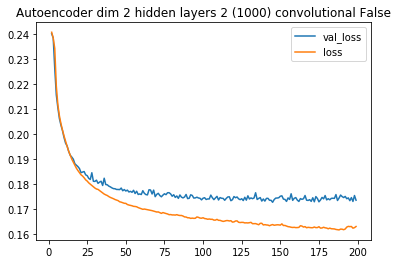

Error train: 0.1631863016540354 Error val: 0.17369287395477295
Codificación tamaño 2


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


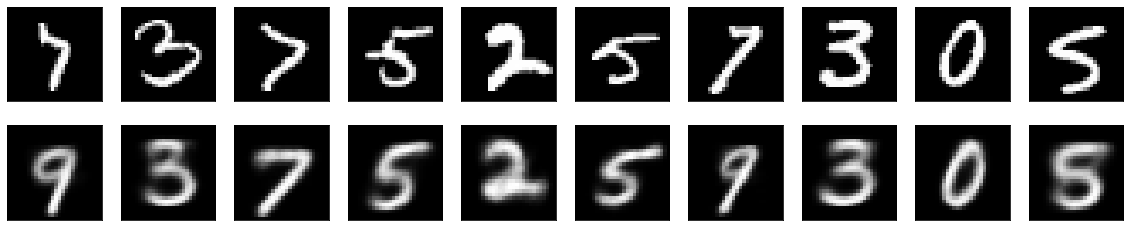

Classification Accuracy dim 2 PCA 0.44


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 2 0.81
Autoencoder dim 4 hidden layers 2 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_44 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 2004      
_________________________________________________________________
dense_46 (Dense)             (None, 500)               2500      
_________________________________________________________________
dense_47 (Dense)             (None, 1000)              501000    
_________________________

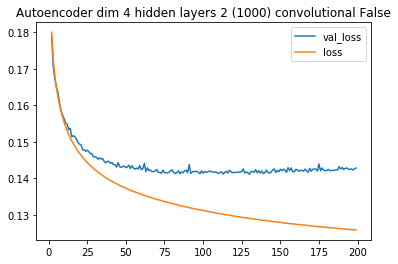

Error train: 0.12584159421270544 Error val: 0.1428085202217102
Codificación tamaño 4


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


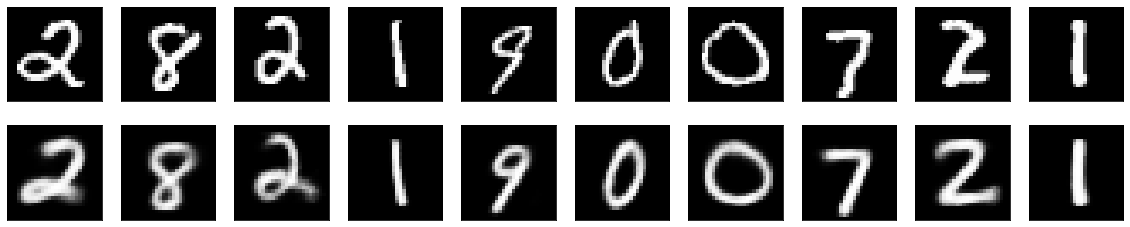

Classification Accuracy dim 4 PCA 0.65


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 4 0.92
Autoencoder dim 8 hidden layers 2 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_50 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 4008      
_________________________________________________________________
dense_52 (Dense)             (None, 500)               4500      
_________________________________________________________________
dense_53 (Dense)             (None, 1000)              501000    
_________________________

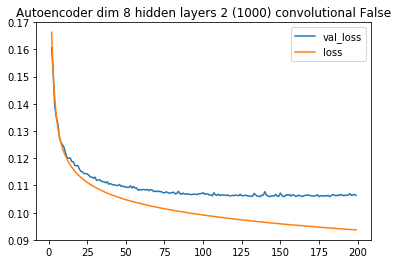

Error train: 0.09367768928896297 Error val: 0.10635835528373719
Codificación tamaño 8


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


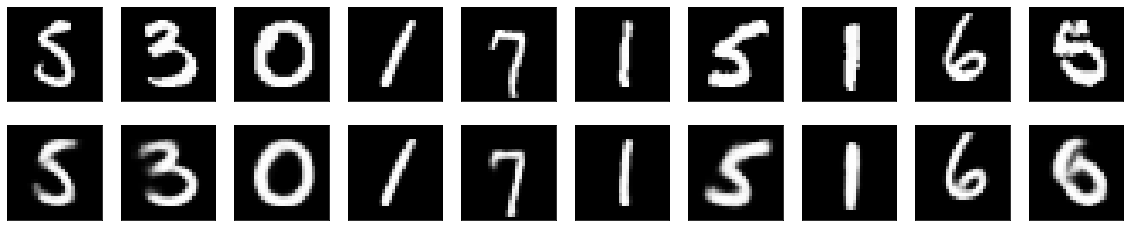

Classification Accuracy dim 8 PCA 0.90


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 8 0.96
Autoencoder dim 16 hidden layers 2 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_56 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_57 (Dense)             (None, 16)                8016      
_________________________________________________________________
dense_58 (Dense)             (None, 500)               8500      
_________________________________________________________________
dense_59 (Dense)             (None, 1000)              501000    
________________________

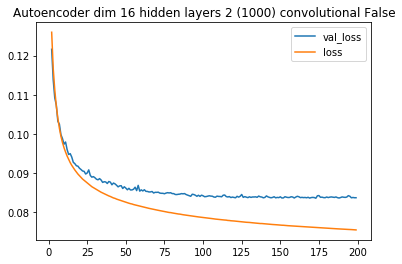

Error train: 0.07552234041474082 Error val: 0.08373590396642686
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


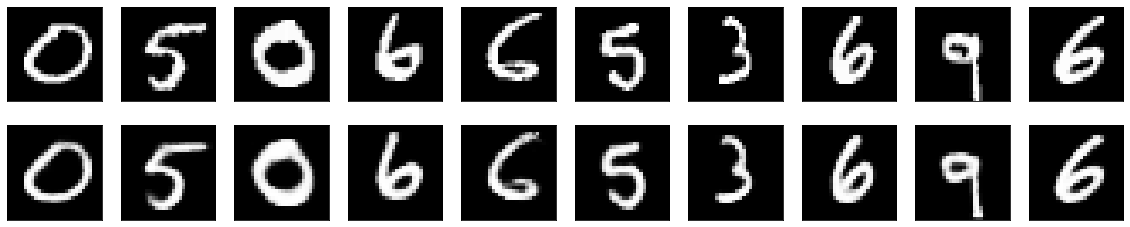

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.97


In [15]:
train_errors2 = []
val_errors2 = []
pca_scores2 = []
ae_scores2 = []
pca_times2 = []
ae_times2 = []
for encod_dim in encod_sizes:
    hist = build_model(x_train1, x_val1, encod_dim, hidden_layers=2,
                       encoder_activation=activations.relu)
    train_errors2.append(hist.history['loss'][-1])
    val_errors2.append(hist.history['val_loss'][-1])
    visualize_encoder(x_test1, encod_dim, hidden_layers=2,
                      encoder_activation=activations.relu)
    pca, pca_train, pca_test, pca_score, ae_score, pca_time, ae_time = compare_pca_autoencoder(
        x_train1, y_train, x_test1, y_test, encod_dim, hidden_layers=2,
        encoder_activation=activations.relu)
    pca_scores2.append(pca_score)
    ae_scores2.append(ae_score)
    pca_times2.append(pca_time)
    ae_times2.append(ae_time) 

Visualmente, ya vemos que usando capas ocultas logra que la reconstrucción de la imagen sea mejor, que en el caso de no tener capas ocultas, para un mismo tamaño de reducción de dimensionalidad. Revisaremos ahora con 4 capas ocultas, y finalmente revisaremos gráficos de desempeño.

Autoencoder dim 2 hidden layers 4 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_62 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_63 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_64 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 252       
_________________________________________________________________
dense_

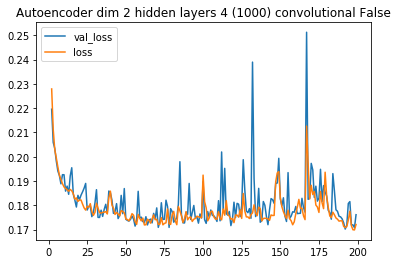

Error train: 0.17210837655500932 Error val: 0.17613996727466583
Codificación tamaño 2


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


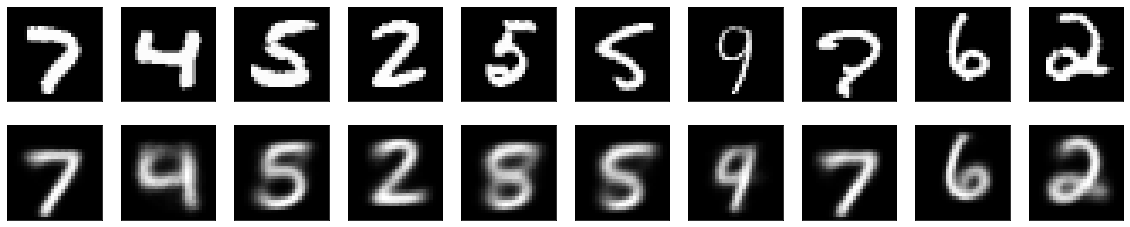

Classification Accuracy dim 2 PCA 0.44


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 2 0.80
Autoencoder dim 4 hidden layers 4 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_72 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_73 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_74 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 504       
_________________________

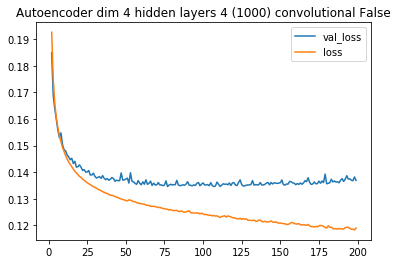

Error train: 0.11896154887351122 Error val: 0.13689227495193482
Codificación tamaño 4


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


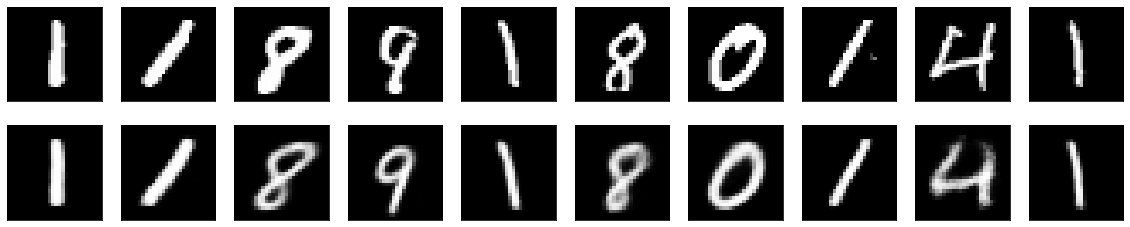

Classification Accuracy dim 4 PCA 0.65


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 4 0.94
Autoencoder dim 8 hidden layers 4 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_82 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_83 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_84 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_85 (Dense)             (None, 8)                 1008      
_________________________

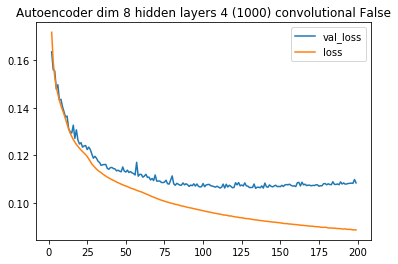

Error train: 0.08861820818619294 Error val: 0.1083941393852234
Codificación tamaño 8


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


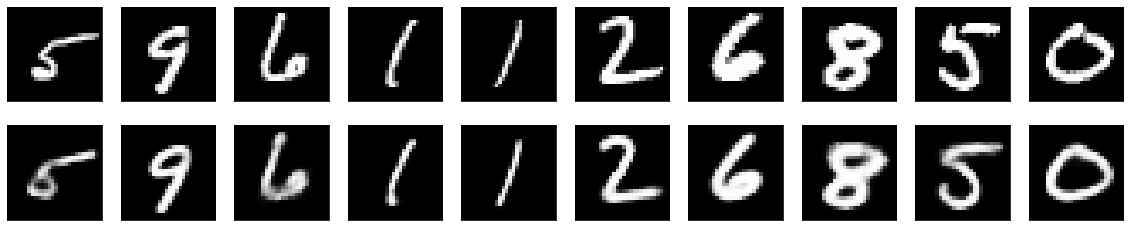

Classification Accuracy dim 8 PCA 0.90


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 8 0.96
Autoencoder dim 16 hidden layers 4 hidden num 1000 convolutional False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_92 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_93 (Dense)             (None, 250)               125250    
_________________________________________________________________
dense_94 (Dense)             (None, 125)               31375     
_________________________________________________________________
dense_95 (Dense)             (None, 16)                2016      
________________________

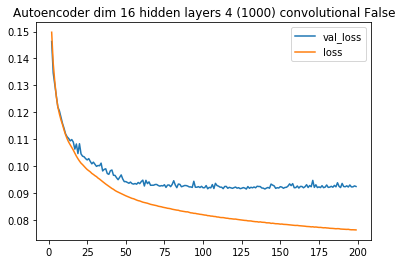

Error train: 0.07637418773065914 Error val: 0.09249035420417785
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


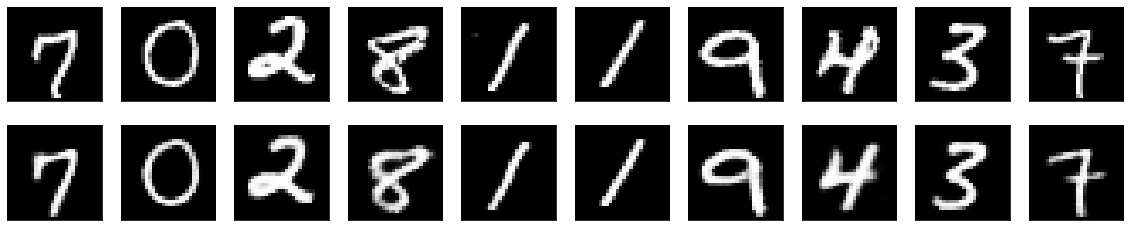

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.97


In [16]:
train_errors4 = []
val_errors4 = []
pca_scores4 = []
ae_scores4 = []
pca_times4 = []
ae_times4 = []
for encod_dim in encod_sizes:
    hist = build_model(x_train1, x_val1, encod_dim, hidden_layers=4,
                       encoder_activation=activations.relu)
    train_errors4.append(hist.history['loss'][-1])
    val_errors4.append(hist.history['val_loss'][-1])
    visualize_encoder(x_test1, encod_dim, hidden_layers=4,
                      encoder_activation=activations.relu)
    pca, pca_train, pca_test, pca_score, ae_score, pca_time, ae_time = compare_pca_autoencoder(
        x_train1, y_train, x_test1, y_test, encod_dim, hidden_layers=4,
        encoder_activation=activations.relu)
    pca_scores4.append(pca_score)
    ae_scores4.append(ae_score)
    pca_times4.append(pca_time)
    ae_times4.append(ae_time)

Es importante notar que al agregar capas ocultas, vemos que el error de validación llega a un punto donde ya no logra descender más, por lo que se despega del error de entrenamiento. Si bien esto es una indicación de sobreajuste, vemos que el error de validación no aumenta realmente, sino que se mantiene. En este caso la red está memorizando los datos de entrenamiento, sin empeorar su error de generalización. En el caso de 4 capas ocultas y 2 dimensiones, esto no ocurre, pero visualmente vemos que la reconstrucción no es del todo satisfactoria.

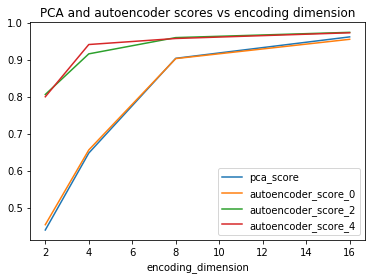

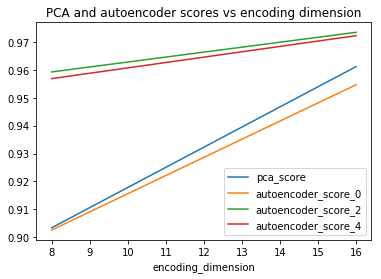

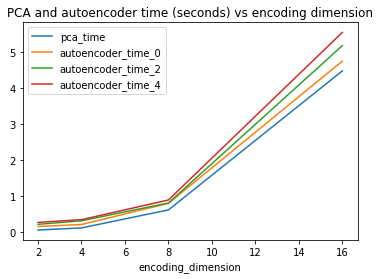

In [17]:
to_plot = pd.DataFrame(data={'encoding_dimension': encod_sizes,
                             'pca_score': pca_scores[:len(encod_sizes)],
                             'autoencoder_score_0': ae_scores[:len(encod_sizes)],
                             'pca_time': pca_times[:len(encod_sizes)],
                             'autoencoder_time_0': ae_times[:len(encod_sizes)],
                             'autoencoder_score_2': ae_scores2,
                             'autoencoder_time_2': ae_times2,
                             'autoencoder_score_4': ae_scores4,
                             'autoencoder_time_4': ae_times4})
to_plot.plot(x='encoding_dimension',
             y=['pca_score', 'autoencoder_score_0', 'autoencoder_score_2',
                'autoencoder_score_4'],
             title='PCA and autoencoder scores vs encoding dimension')
pyplot.show()
to_plot2 = pd.DataFrame(data={'encoding_dimension': encod_sizes[2:],
                              'pca_score': pca_scores[2:len(encod_sizes)],
                              'autoencoder_score_0': ae_scores[2:len(encod_sizes)],
                              'pca_time': pca_times[2:len(encod_sizes)],
                              'autoencoder_time_0': ae_times[2:len(encod_sizes)],
                              'autoencoder_score_2': ae_scores2[2:],
                              'autoencoder_time_2': ae_times2[2:],
                              'autoencoder_score_4': ae_scores4[2:],
                              'autoencoder_time_4': ae_times4[2:]})
to_plot2.plot(x='encoding_dimension',
              y=['pca_score', 'autoencoder_score_0', 'autoencoder_score_2',
                 'autoencoder_score_4'],
              title='PCA and autoencoder scores vs encoding dimension')
pyplot.show()
to_plot.plot(x='encoding_dimension',
             y=['pca_time', 'autoencoder_time_0', 'autoencoder_time_2',
                'autoencoder_time_4'],
             title='PCA and autoencoder time (seconds) vs encoding dimension')
pyplot.show()

A partir del primer gráfico, podemos concluir que el agregar capas ocultas al autoencoder, la reconstrucción resulta útil para clasificar los dígitos usando el modelo de vecinos más cercanos. De hecho, tanto 2 como 4 capas ocultas consiguen aumentar considerablemente el score de clasificación, especialmente para pocas dimensiones. Esto contrasta con lo visto anteriormente, que sin capas ocultas PCA resulta mejor. En cuanto al tiempo de ejecución (último gráfico), vemos que para la cantidad de dimensiones revisada ($\leq 16$), el tiempo de ejecución con capas ocultas es solo levemente superior al tiempo sin capas ocultas o usando PCA. Concluimos entonces que usando un autoencoder con capas ocultas, resulta mejor que PCA para la tarea posterior de clasificar los dígitos en la representación con dimensión reducida, manteniendo tiempos de ejecución similares. Un autoencoder sin capas ocultas es más rápido, pero con un error mayor.

En los experimentos posteriores, usaremos dos capas ocultas, pues obtiene buen desempeño, con tiempo de entrenamiento menor que cuatro capas ocultas.

> e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualícelas usando la herramienta *TSNE* disponible en la librería *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

In [18]:
# Numero de objetos a graficar
nplot = 300  # warning: mind your memory!

def make_chart(local_encoded_train, local_y_train, title, use_tsne=True):
    if use_tsne:
        model = manifold.TSNE(n_components=2, random_state=0)
        if len(local_encoded_train.shape) > 2:
            local_encoded_train = local_encoded_train.reshape(
                local_encoded_train.shape[0],
                local_encoded_train.shape[1] * local_encoded_train.shape[2] *
                local_encoded_train.shape[3])
        local_encoded_train = model.fit_transform(local_encoded_train)
    pyplot.figure(figsize=(10, 10))
    colors = {0: 'b', 1: 'g', 2: 'r', 3: 'c', 4: 'm', 5: 'y', 6: 'k',
              7: 'orange', 8: 'darkgreen', 9: 'maroon'}
    # markers = {0: 'o', 1: '+', 2: 'v', 3: '<', 4: '>', 5: '^', 6: 's',
    #            7: 'p', 8: '*', 9: 'x'}
    for idx in range(nplot):
        label = local_y_train[idx]
        line = pyplot.plot(
            local_encoded_train[idx][0], local_encoded_train[idx][1],
            color=colors[label], marker='')
        pyplot.text(local_encoded_train[idx][0], local_encoded_train[idx][1],
                    str(label), size=15, va='center', ha='center', clip_on=True,
                    color=colors[label])
    pyplot.title(title)
    pyplot.show()

def qualitative_compare(local_x_train, local_y_train,
                        local_x_test, local_y_test, encod_dim,
                        hidden_layers=0, hidden_num=1000,
                        encoder_activation=None, include_mini_ae=True):
    encoder, decoder, autoencoder = load_autoencoder(
        local_x_test.shape[1], encod_dim, hidden_layers=hidden_layers,
        hidden_num=hidden_num, encoder_activation=encoder_activation)
    encoded_train = encoder.predict(local_x_train[:nplot])
    make_chart(encoded_train, local_y_train,
               'Autoencoder dim {}'.format(encod_dim))
    pca, pca_train, pca_test, pca_score, ae_score, pca_time, ae_time = compare_pca_autoencoder(
        local_x_train, local_y_train, local_x_test, local_y_test, encod_dim,
        hidden_layers=hidden_layers, hidden_num=hidden_num,
        encoder_activation=encoder_activation)
    pca_train = pca_train[:nplot]
    make_chart(pca_train, local_y_train, 'PCA dim {}'.format(encod_dim))
    if include_mini_ae:
        encoder, decoder, autoencoder = load_autoencoder(
            local_x_test.shape[1], 2, hidden_layers=hidden_layers,
            hidden_num=hidden_num, encoder_activation=encoder_activation)
        encoded_train = encoder.predict(x_train1[:nplot])
        make_chart(encoded_train, local_y_train, 'Autoencoder dim 2',
                   use_tsne=False)
    return pca_score, ae_score

/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


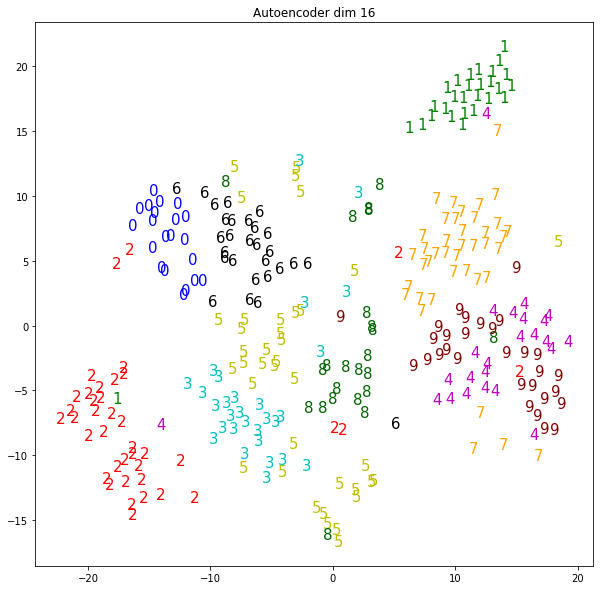

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.97


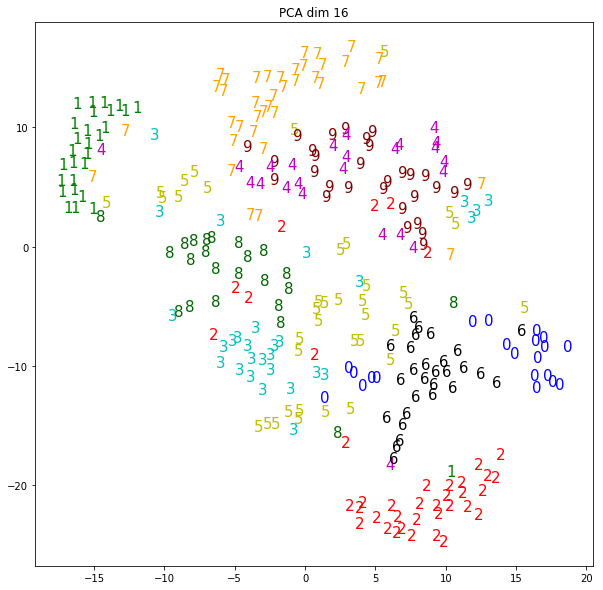

/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


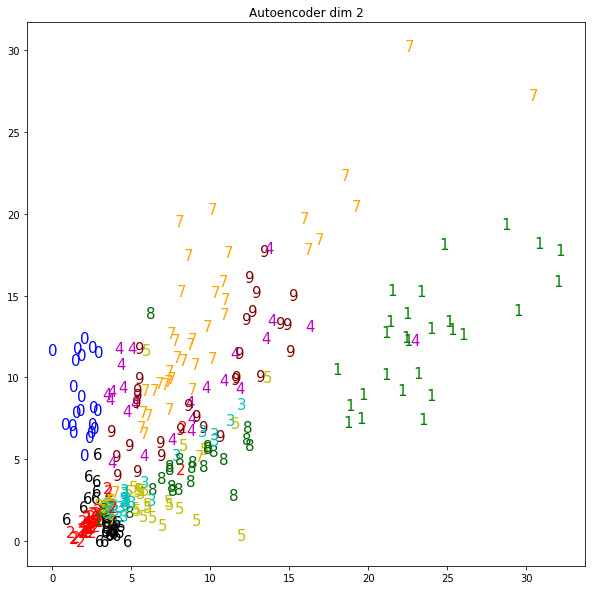

(0.961, 0.9735)

In [19]:
qualitative_compare(x_train1, y_train, x_test1, y_test, 16, hidden_layers=2,
                    encoder_activation=activations.relu)

Primero, debemos describir qué es t-SNE. Es un algoritmo que reduce la dimensionalidad de puntos de mayor dimensionalidad, intentando que la distribución de las distancias entre los puntos sea lo más similar a la distribución en más dimensiones. La distribución de las distancias ajustada es una *t-student*.

Como se mencionó anteriormente, se eligió un autoencoder de dos capas ocultas con 16 unidades latentes. En la representación lograda por t-SNE, vemos que efectivamente los números parecen quedar más separados entre sí en el caso del autoencoder, que en el caso de PCA con la misma cantidad de dimensiones. Algunos números quedan traslapados, como el número 2, que está bastante disperso en regiones de otros números. En PCA también ocurre esto para el número 2, pero además las distintas regiones parecen estar mucho más traslapadas en vez de separadas. En el caso de la visualización del autoencoder de dimensión 2, vemos que los números quedan mucho menos separables, excepto por los extremos como el 1 y el 0.

> f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [20]:
# Keras received by default channel dimension at the end, so add a dimension 1
x_train2 = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_val2 = np.reshape(x_val, (len(x_val), 28, 28, 1))
x_test2 = np.reshape(x_test, (len(x_test), 28, 28, 1))
print('Forma de x_train2:', x_train2.shape)
print('Forma de x_val2:', x_val2.shape)
print('Forma de x_test2:', x_test2.shape)

Forma de x_train2: (55000, 28, 28, 1)
Forma de x_val2: (5000, 28, 28, 1)
Forma de x_test2: (10000, 28, 28, 1)


Los datos quedan entonces en tensores del tamaño de la imágen ($28 \times 28$) y cantidad de canales, en este caso uno.

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

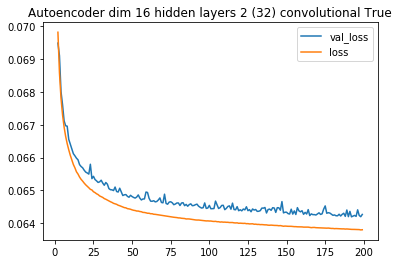

Error train: 0.06380282120108605 Error val: 0.06426885213851928
Codificación tamaño 16


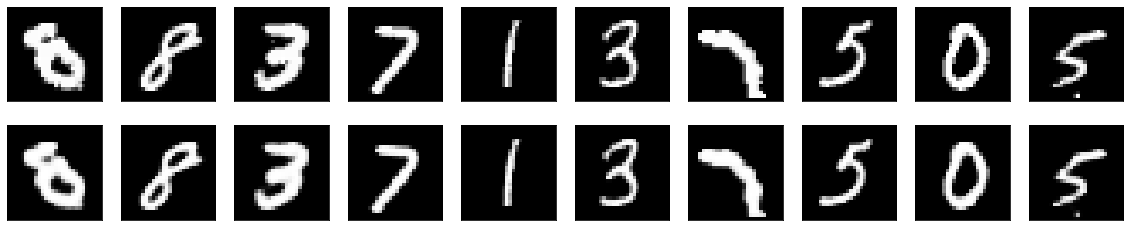

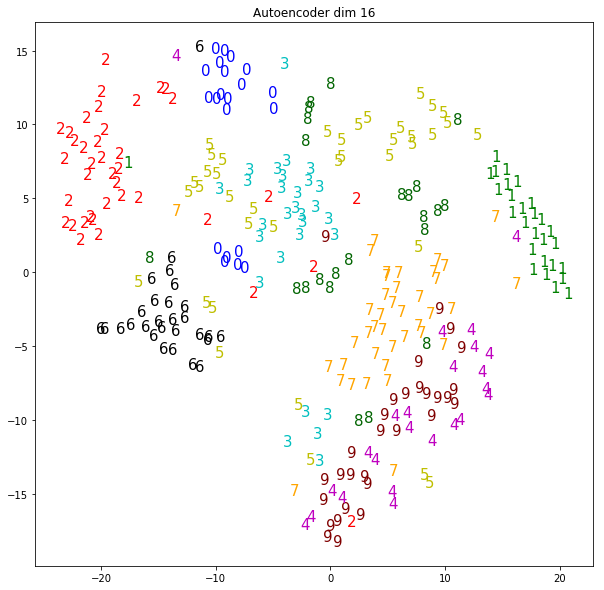

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


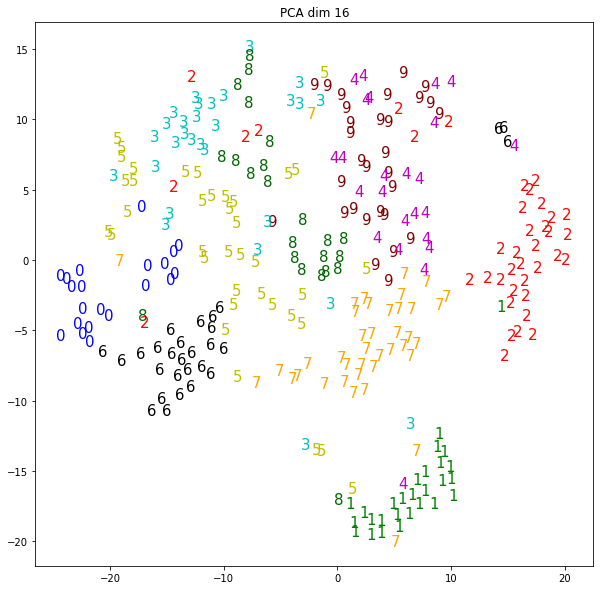

(0.9609, 0.964)

In [21]:
build_model(x_train2, x_val2, 16, hidden_layers=2, hidden_num=32,
            optimizer=optimizers.Adam(), encoder_activation=activations.relu)
visualize_encoder(x_test2, 16, hidden_layers=2, hidden_num=32,
                  encoder_activation=activations.relu)
qualitative_compare(
    x_train2, y_train, x_test2, y_test, 16,
    hidden_layers=2, hidden_num=32,
    encoder_activation=activations.relu, include_mini_ae=False)

Vemos que el autoencoder convolucional logra un error de reconstrucción mucho menor en comparación con los que usan redes feedforward (0.064 vs. 0.083), y con una cantidad de parámetros mucho menor (12 mil en comparación con 2,5 millones en una red feedforward de 2 capas ocultas con 16 unidades latentes de encoding). El éxito de las redes convolucionales es general para el procesamiento de imágenes, como en este caso, ya que incluye la información de los vecinos, con una cantidad mucho menor de parámetros.

Sin embargo, vemos que el score de generalización para la tarea de clasificación, resulta menor. Esto puede deberse a que simplemente deberíamos usar una red más grande en el caso de usar una red convolucional. Esta manera de comparar tiene el problema que en ambos casos estamos usando el conjunto de pruebas para medir. Una manera más adecuada sería usar solo el conjunto de validación, o cross validation, ya que puede ser casualidad de cómo se eligió cada conjunto. El foco de esta tarea es comprender los autoencoders, por lo que no lo haremos.

### 2.2 Denoising
Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

> a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

Crearemos una función auxiliar para agregar el ruido descrito a las imágenes:

In [22]:
def get_noisy_data(noise_level, flatten=True):
    noise_level = 1.0 - noise_level
    noise_mask = binomial(n=1, p=noise_level, size=x_train.shape)
    noisy_x_train = x_train * noise_mask
    noise_mask = binomial(n=1, p=noise_level, size=x_val.shape)
    noisy_x_val = x_val * noise_mask
    noise_mask = binomial(n=1, p=noise_level, size=x_test.shape)
    noisy_x_test = x_test * noise_mask
    if flatten:
        noisy_x_train = noisy_x_train.reshape((len(x_train),
                                               np.prod(x_train.shape[1:])))
        noisy_x_val = noisy_x_val.reshape((len(x_val),
                                           np.prod(x_val.shape[1:])))
        noisy_x_test  = noisy_x_test.reshape((len(x_test),
                                              np.prod(x_test.shape[1:])))
    else:
        noisy_x_train = np.reshape(noisy_x_train, (len(x_train), 28, 28, 1))
        noisy_x_val = np.reshape(noisy_x_val, (len(x_val), 28, 28, 1))
        noisy_x_test = np.reshape(noisy_x_test, (len(x_test), 28, 28, 1))
    return noisy_x_train, noisy_x_val, noisy_x_test

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ítem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

En esta parte de la pregunta usaremos un autoencoder convolucional, ya que como vimos en la primera parte de esta pregunta, obtiene mejores resultados de reconstrucción, con una cantidad menor de parámetros.

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

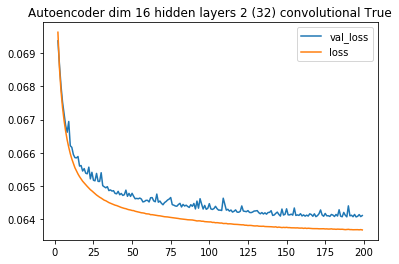

Error train: 0.06367913594029166 Error val: 0.06411132972240448
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


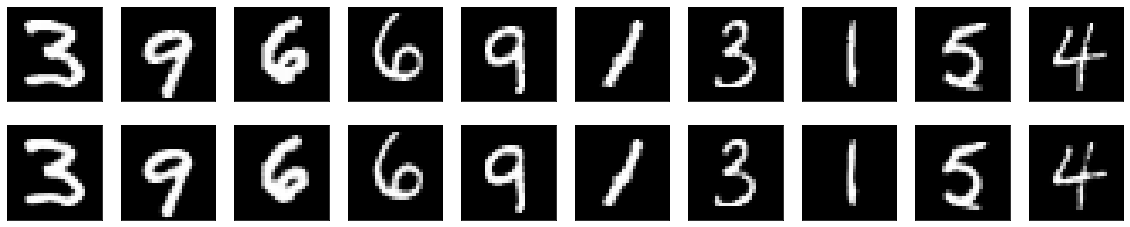

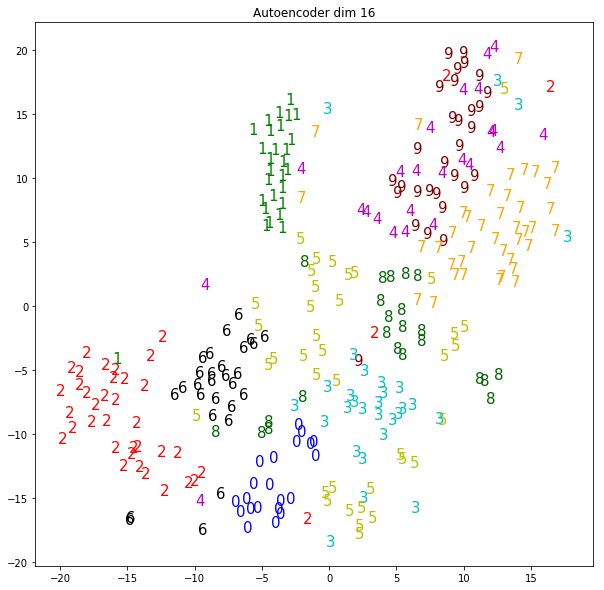

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


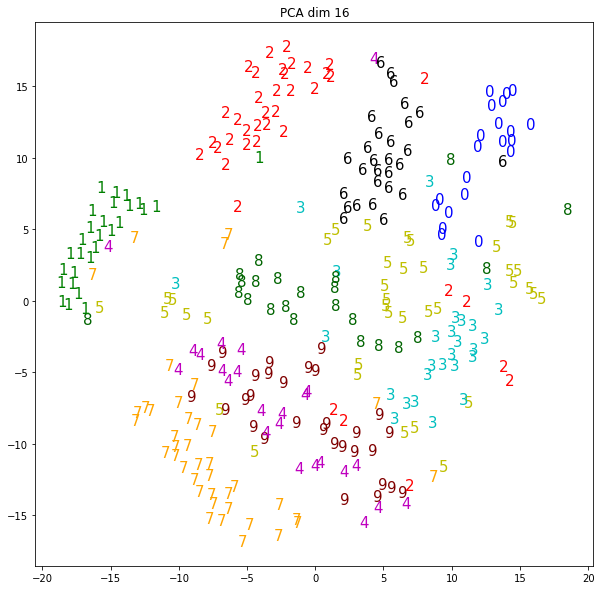

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

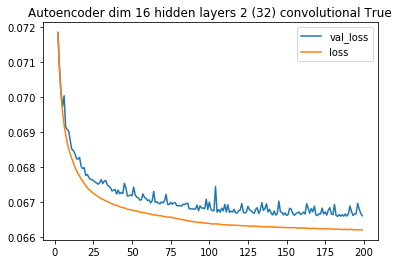

Error train: 0.06621942899552259 Error val: 0.06661878161430358
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


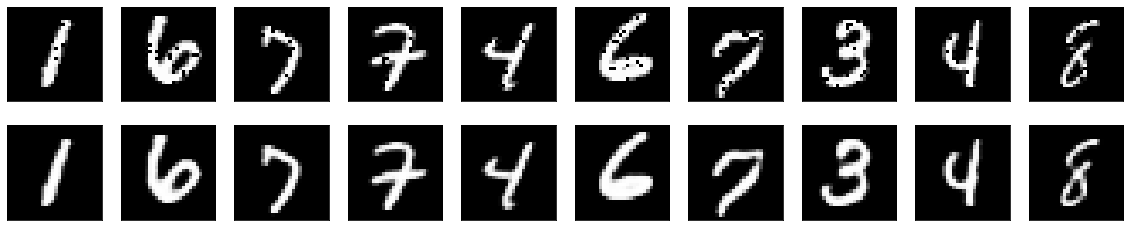

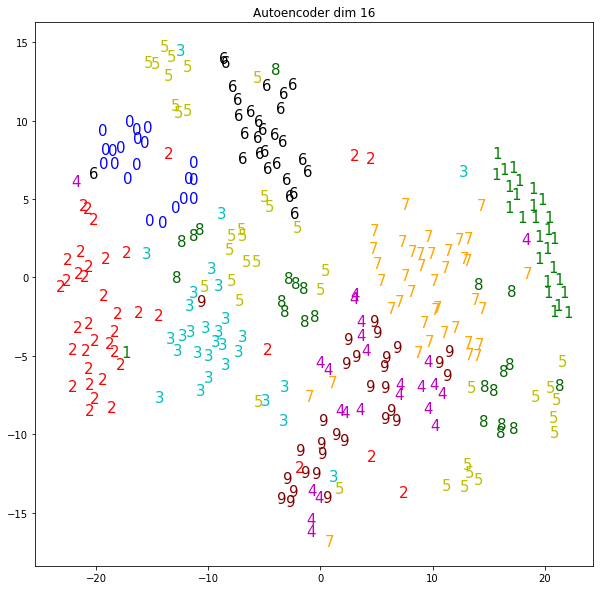

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


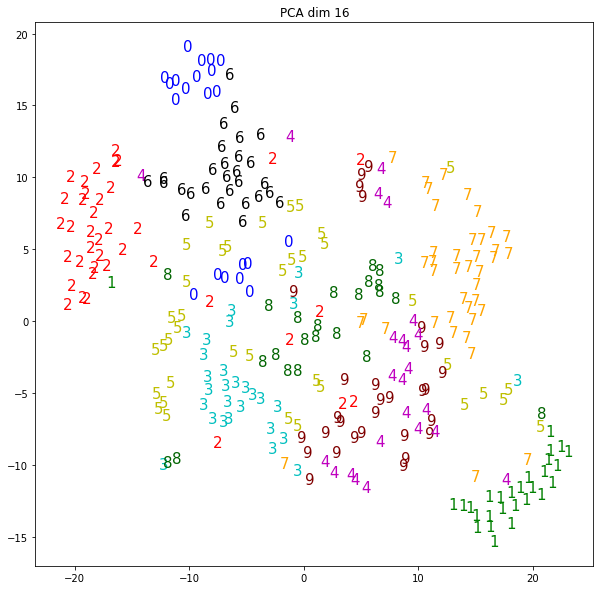

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

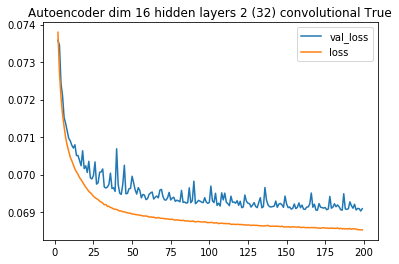

Error train: 0.06852709157466888 Error val: 0.06909254714250565
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


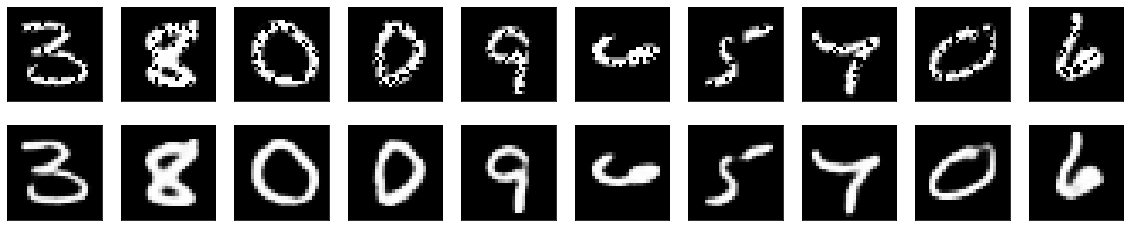

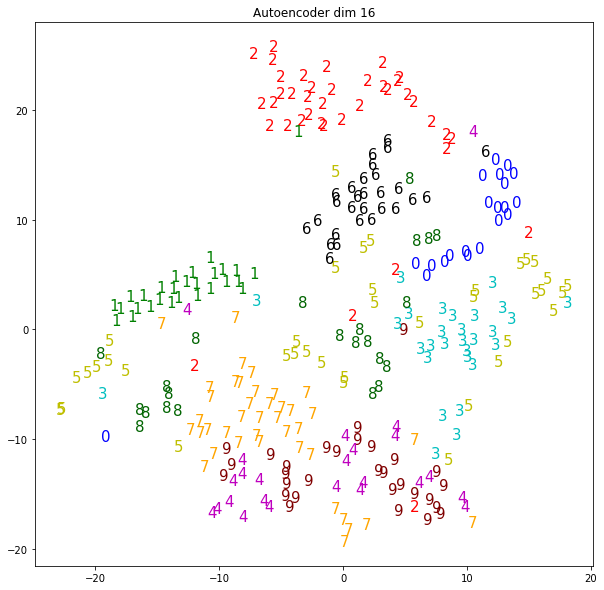

Classification Accuracy dim 16 PCA 0.95


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


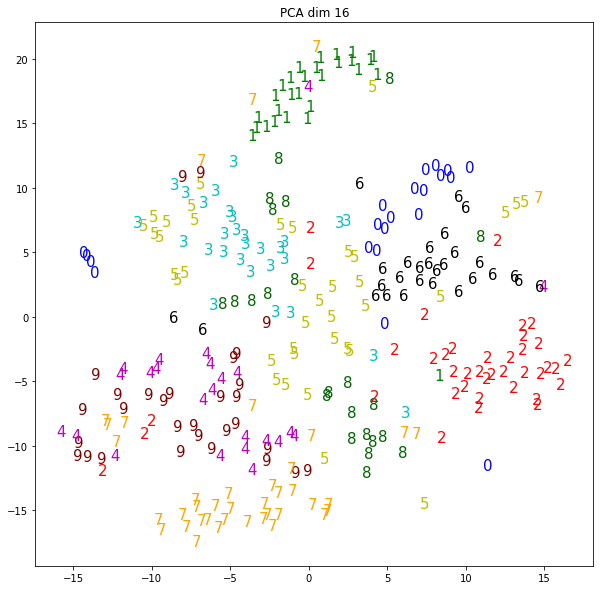

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

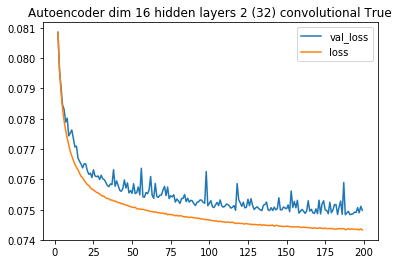

Error train: 0.07433453356461091 Error val: 0.07498188579082489
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


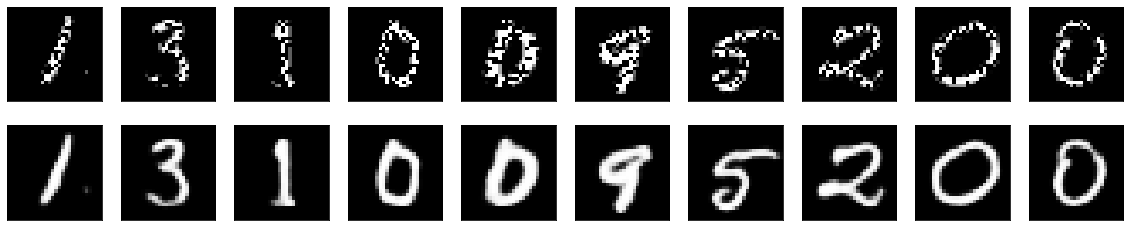

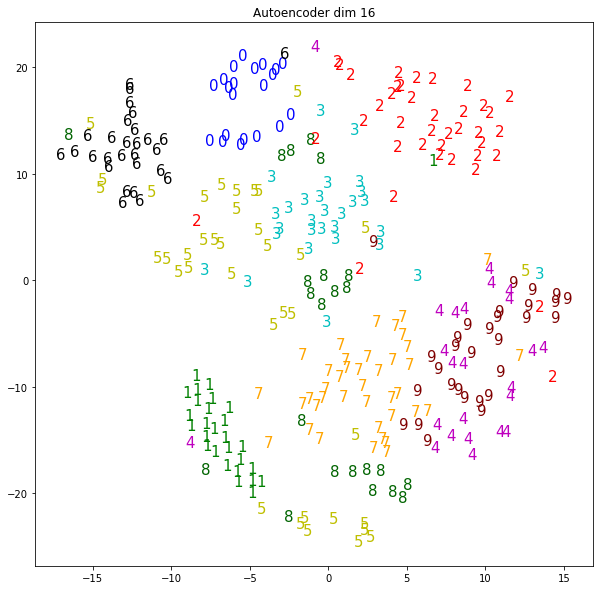

Classification Accuracy dim 16 PCA 0.93


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


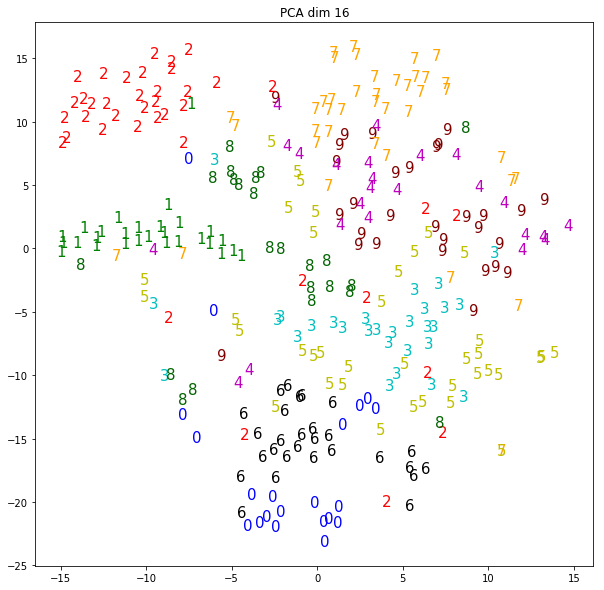

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

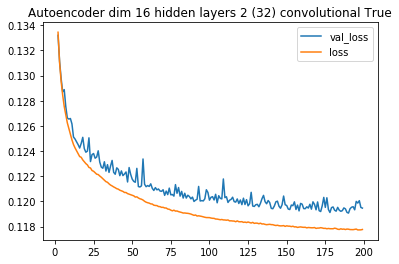

Error train: 0.1177701528321613 Error val: 0.11946992037296295
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


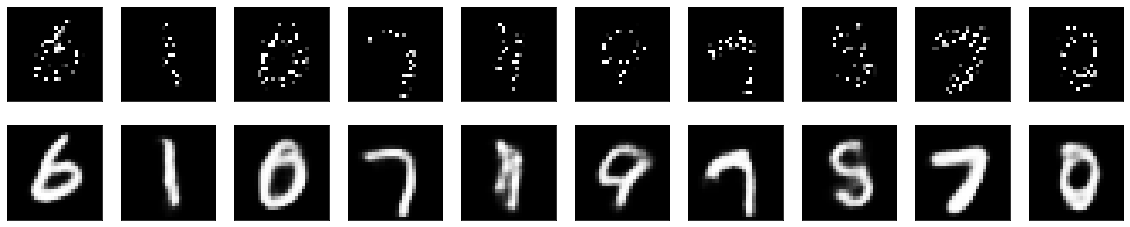

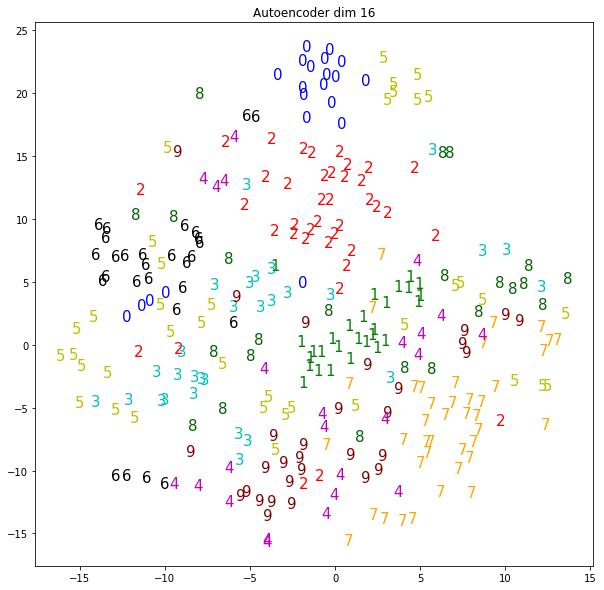

Classification Accuracy dim 16 PCA 0.73


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.89


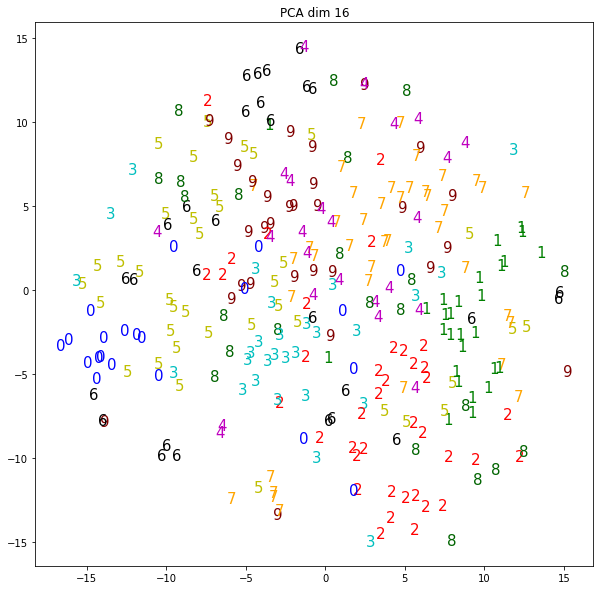

In [23]:
train_errors = []
val_errors = []
pca_scores = []
ae_scores = []
noise_levels = [0.0, 0.1, 0.2, 0.4, 0.8]
for noise_level in noise_levels:
    local_x_train, local_x_val, local_x_test = get_noisy_data(
        noise_level, flatten=False)
    hist = build_model(local_x_train, local_x_val,
                       16, hidden_layers=2, hidden_num=32,
                       optimizer=optimizers.Adam(),
                       encoder_activation=activations.relu,
                       extra_x_train=x_train2, extra_x_val=x_val2)
    train_errors.append(hist.history['loss'][-1])
    val_errors.append(hist.history['val_loss'][-1])
    visualize_encoder(local_x_test, 16, hidden_layers=2, hidden_num=32,
                      encoder_activation=activations.relu)
    pca_score, ae_score = qualitative_compare(
        local_x_train, y_train, local_x_test, y_test,
        16, hidden_layers=2, hidden_num=32,
        encoder_activation=activations.relu, include_mini_ae=False)
    pca_scores.append(pca_score)
    ae_scores.append(ae_score)

Vemos que, si bien el error de reconstrucción va subiendo con la cantidad de ruido (como veremos en el gráfico a continuación), la revisión visual de la reconstrucción es sorprendentemente buena.

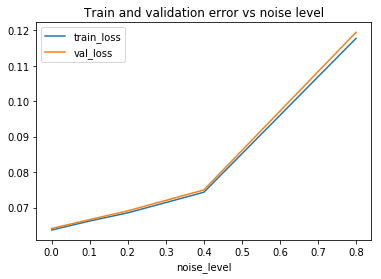

In [24]:
to_plot = pd.DataFrame(data={'noise_level': noise_levels,
                             'train_loss': train_errors,
                             'val_loss': val_errors})
to_plot.plot(x='noise_level', y=['train_loss', 'val_loss'],
             title='Train and validation error vs noise level')
pyplot.show()

En este gráfico vemos cómo el error de reconstrucción sube a medida que sube la cantidad de ruido. Vemos que con tasa de ruido de 0.4, aun el error de reconstrucción se mantiene cercano al óptimo sin ruido. Cuando la cantidad de ruido es 0.8, el error aumenta, lo cual es entendible, ya que significa que cada pixel tiene una probabilidad de 80% de apagarse.

> c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

Los gráficos cualitativos t-SNE se incluyeron arriba, en la salida del entrenamiento. A continuación veremos un gráfico para comparar el desempeño según la cantidad de ruido.

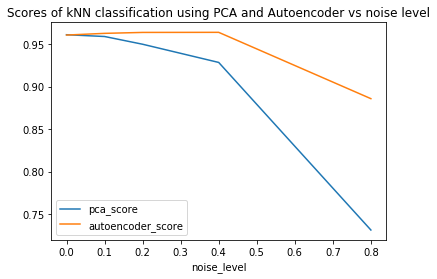

In [25]:
to_plot2 = pd.DataFrame(data={'noise_level': noise_levels,
                              'pca_score': pca_scores,
                              'autoencoder_score': ae_scores})
to_plot2.plot(x='noise_level', y=['pca_score', 'autoencoder_score'],
              title=('Scores of kNN classification using PCA and Autoencoder'
                     ' vs noise level'))
pyplot.show()

Vemos que en el caso de este tipo de ruido, el autoencoder logra codificar las imágenes lo suficientemente bien como para mantener un excelente score de clasificación. PCA, por otro lado, disminuye su desempeño. Esto probablemente se debe a que las direcciones principales elegidas por PCA consideran el ruido, el cual aumenta la varianza en todos los pixeles, haciendo que la varianza sea más parecida en todas las direcciones. Así, PCA pierde información sobre las direcciones principales. El autoencoder, por otro lado, como busca información para reconstruir la imagen original, logra identificar a partir de los pixeles prendidos, las características relevantes para codificar el número, independiente del ruido.

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

Con el fin de comparar otro tipo de ruido, experimentamos agregar un ruido gaussiano a cada pixel. Así, en vez de apagar un pixel, ahora se modifica el valor de cada pixel perturbándolo con una gaussiana escalada por el tamaño del ruido:

In [26]:
def get_gaussian_data(noise_level, flatten=True):
    noise_mask = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    noisy_x_train = x_train + noise_level * noise_mask
    noise_mask = np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)
    noisy_x_val = x_val + noise_level * noise_mask
    noise_mask = np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    noisy_x_test = x_test + noise_level * noise_mask
    if flatten:
        noisy_x_train = noisy_x_train.reshape((len(x_train),
                                               np.prod(x_train.shape[1:])))
        noisy_x_val = noisy_x_val.reshape((len(x_val),
                                           np.prod(x_val.shape[1:])))
        noisy_x_test  = noisy_x_test.reshape((len(x_test),
                                              np.prod(x_test.shape[1:])))
    else:
        noisy_x_train = np.reshape(noisy_x_train, (len(x_train), 28, 28, 1))
        noisy_x_val = np.reshape(noisy_x_val, (len(x_val), 28, 28, 1))
        noisy_x_test = np.reshape(noisy_x_test, (len(x_test), 28, 28, 1))
    return noisy_x_train, noisy_x_val, noisy_x_test

Repetimos el procedimiento utilizado en la pregunta anterior:

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

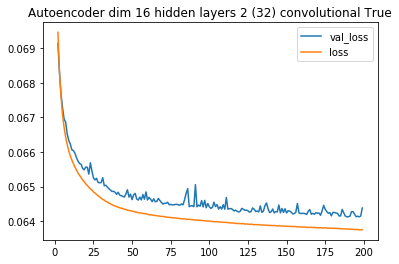

Error train: 0.0637540941953659 Error val: 0.06438040586709977
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


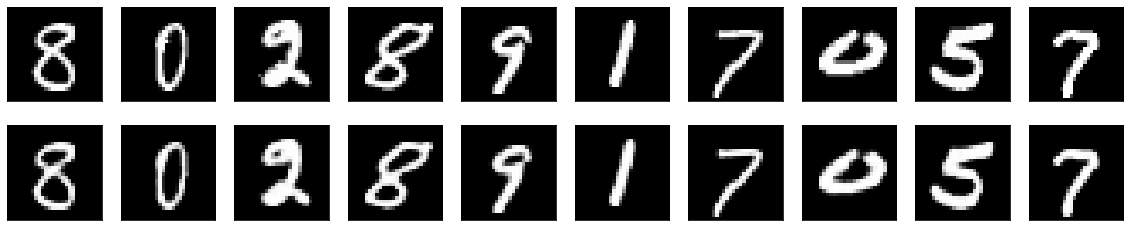

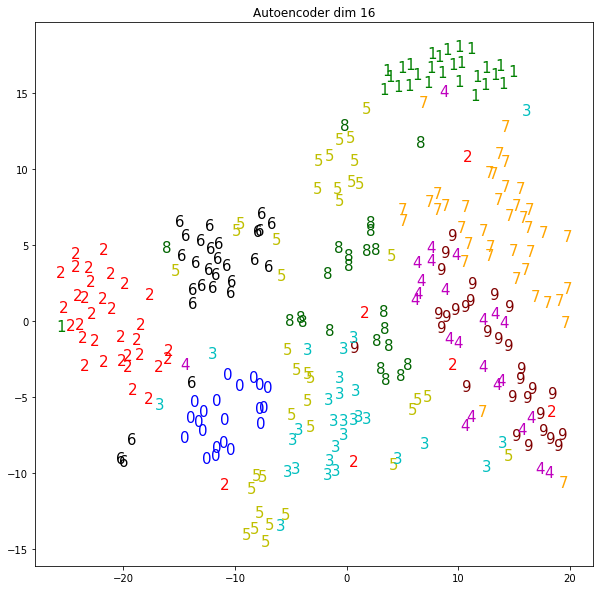

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


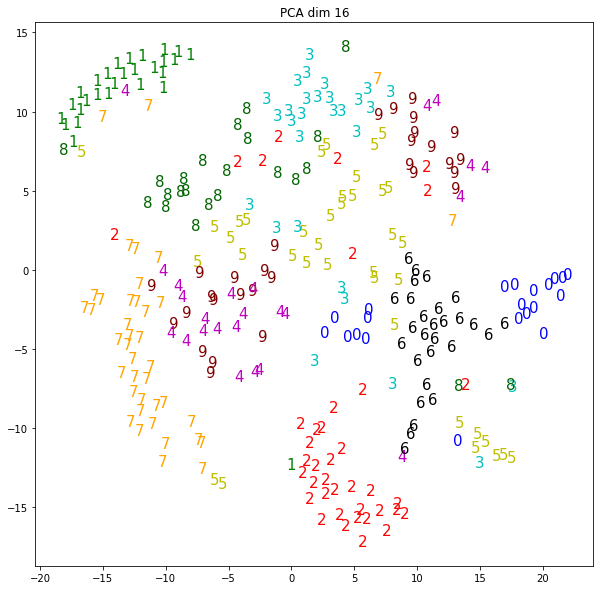

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

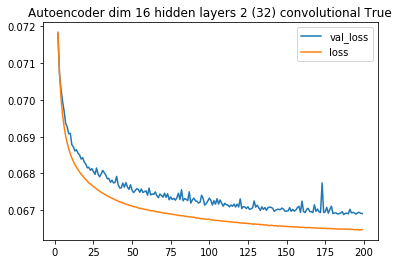

Error train: 0.06647548202384602 Error val: 0.06691090168952941
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


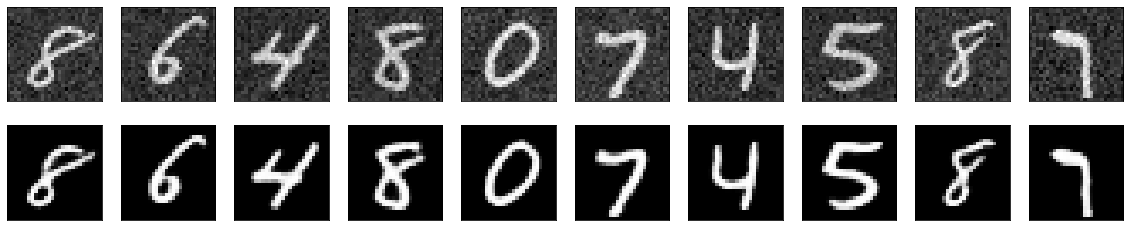

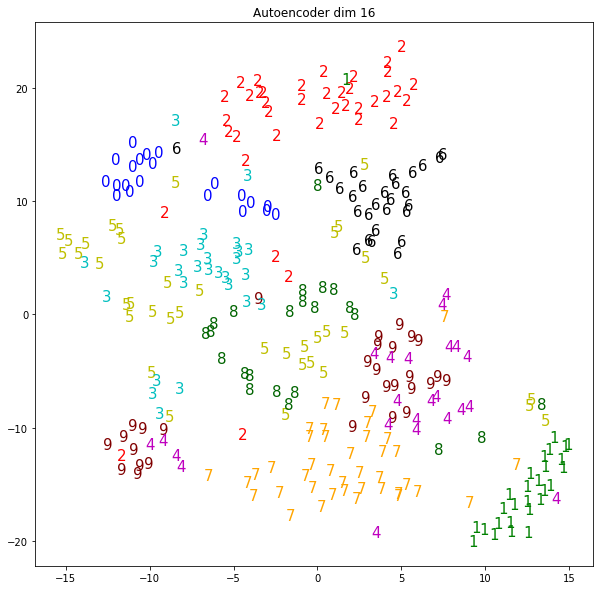

Classification Accuracy dim 16 PCA 0.96


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


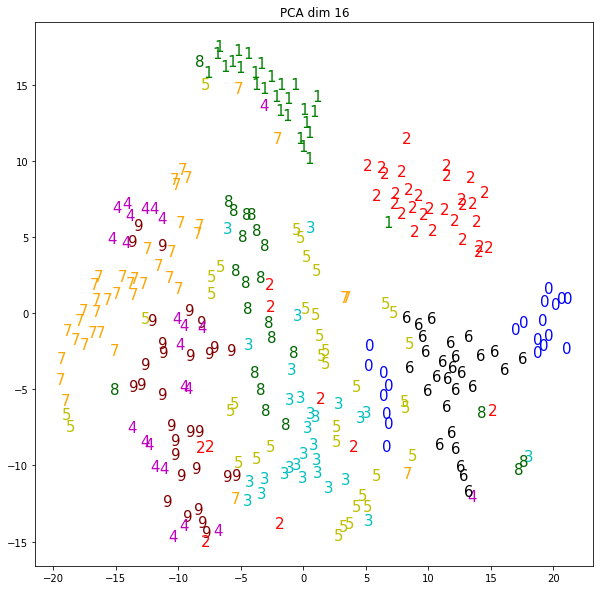

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

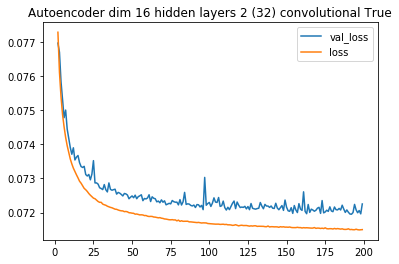

Error train: 0.07149899600852619 Error val: 0.07225215163230896
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


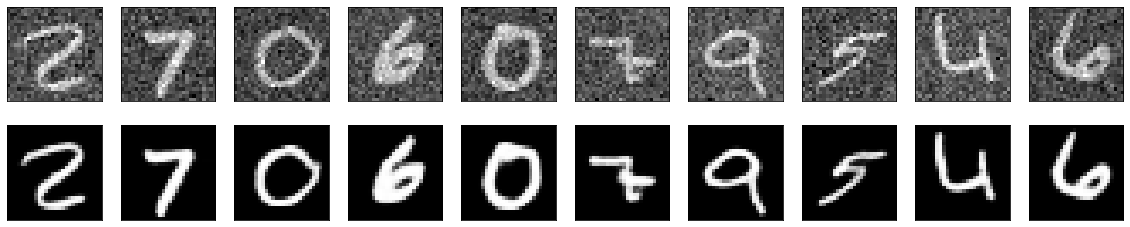

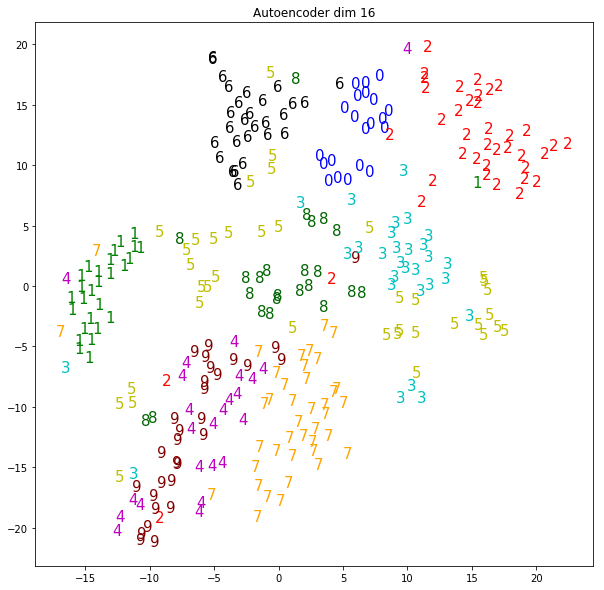

Classification Accuracy dim 16 PCA 0.95


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.97


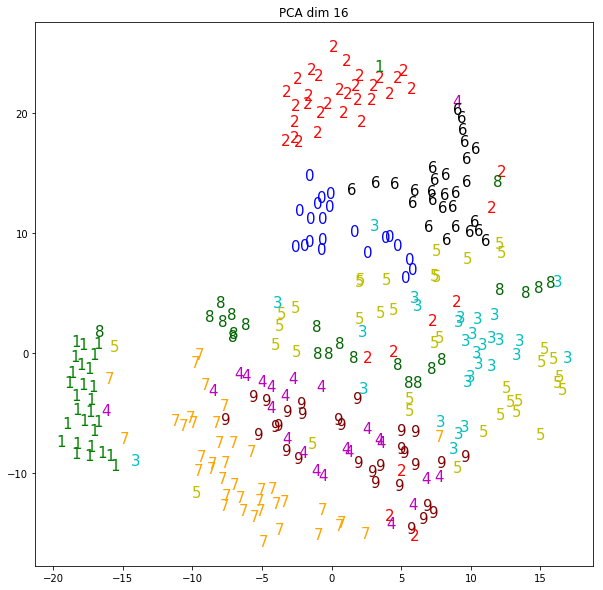

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

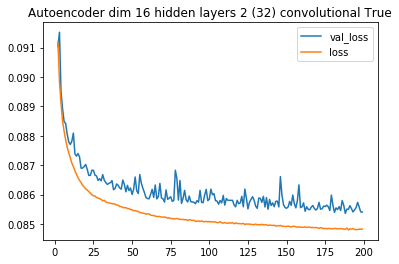

Error train: 0.08483139772957021 Error val: 0.0854084059715271
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


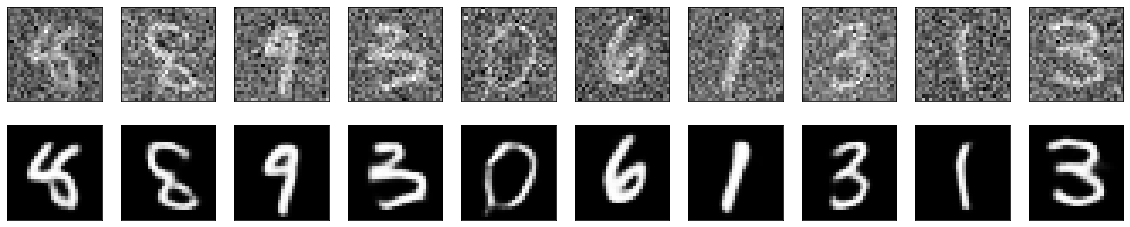

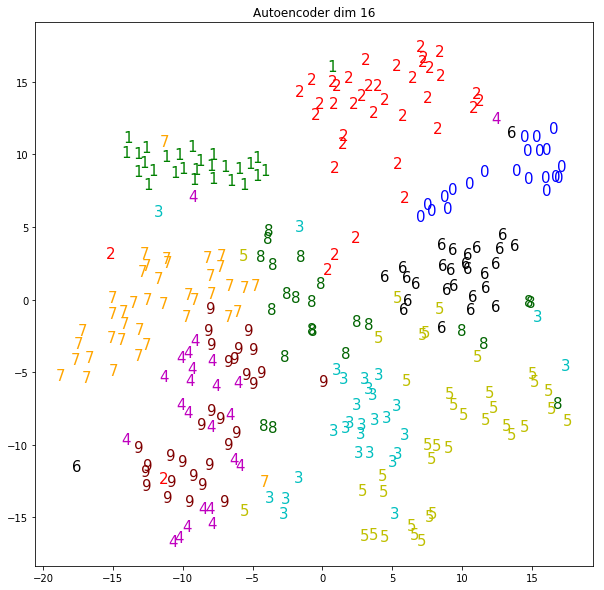

Classification Accuracy dim 16 PCA 0.94


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.96


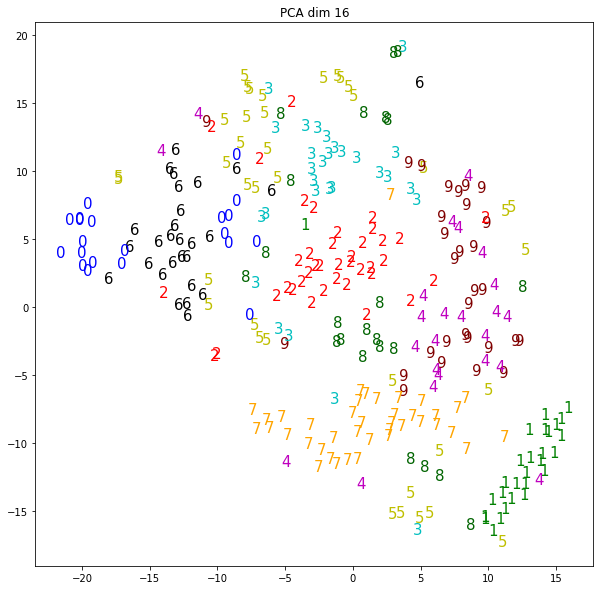

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

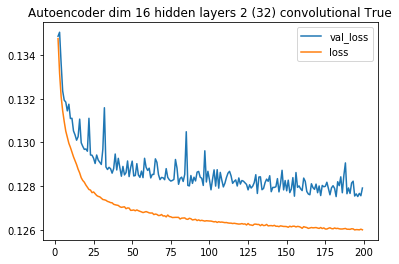

Error train: 0.12600726140629162 Error val: 0.1279165736913681
Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


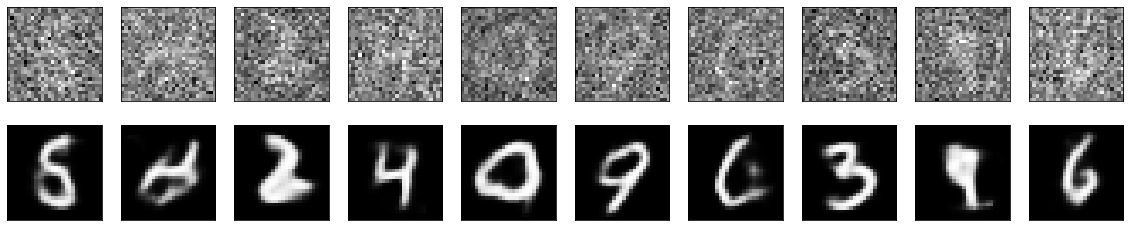

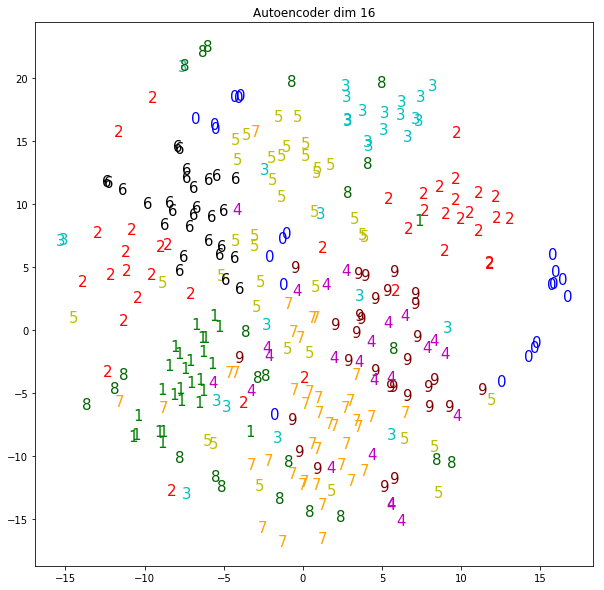

Classification Accuracy dim 16 PCA 0.84


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.89


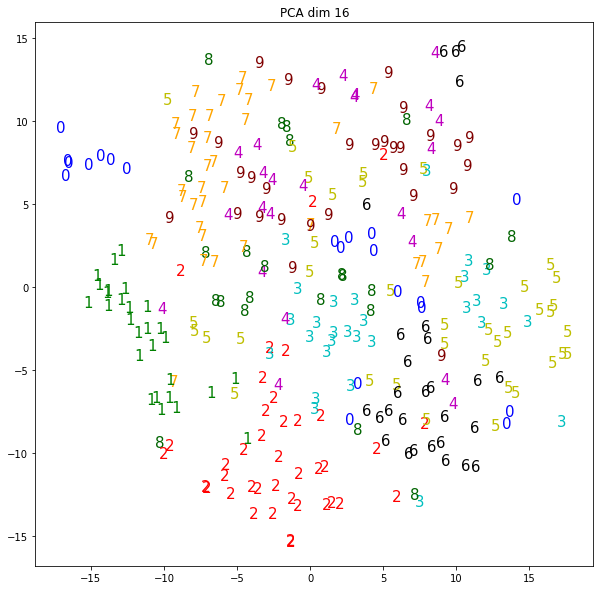

In [27]:
train_errors = []
val_errors = []
pca_scores = []
ae_scores = []
for noise_level in noise_levels:
    local_x_train, local_x_val, local_x_test = get_gaussian_data(
        noise_level, flatten=False)
    hist = build_model(local_x_train, local_x_val,
                       16, hidden_layers=2, hidden_num=32,
                       optimizer=optimizers.Adam(),
                       encoder_activation=activations.relu,
                       extra_x_train=x_train2, extra_x_val=x_val2)
    train_errors.append(hist.history['loss'][-1])
    val_errors.append(hist.history['val_loss'][-1])
    visualize_encoder(local_x_test, 16, hidden_layers=2, hidden_num=32,
                      encoder_activation=activations.relu)
    pca_score, ae_score = qualitative_compare(
        local_x_train, y_train, local_x_test, y_test,
        16, hidden_layers=2, hidden_num=32,
        encoder_activation=activations.relu, include_mini_ae=False)
    pca_scores.append(pca_score)
    ae_scores.append(ae_score)

En la inspección visual vemos que el ruido gaussiano lo que hace es agregar un ruido de fondo, haciendo que el número se vaya "ocultando".

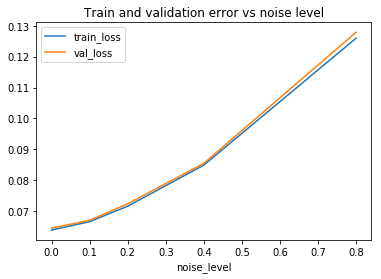

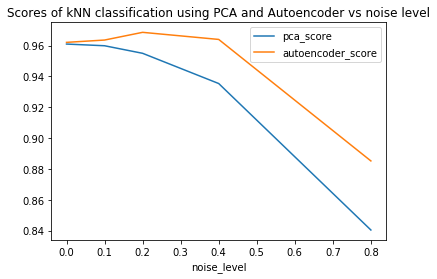

In [28]:
to_plot = pd.DataFrame(data={'noise_level': noise_levels,
                             'train_loss': train_errors,
                             'val_loss': val_errors})
to_plot.plot(x='noise_level', y=['train_loss', 'val_loss'],
             title='Train and validation error vs noise level')
pyplot.show()
to_plot2 = pd.DataFrame(data={'noise_level': noise_levels,
                              'pca_score': pca_scores,
                              'autoencoder_score': ae_scores})
to_plot2.plot(x='noise_level', y=['pca_score', 'autoencoder_score'],
              title=('Scores of kNN classification using PCA and Autoencoder'
                     ' vs noise level'))
pyplot.show()

Al comparar el desempeño del autoencoder en este caso, vemos que el error de reconstrucción aumenta según la cantidad de ruido, de una manera más lineal que en el caso del ruido anterior. Es decir, el autoencoder es menos resistente a este tipo de error gaussiano, al medir el error de reconstrucción. Significa que el ruido de fondo gaussiano hace que el autoencoder no logre obtener de manera ideal las características necesarias para saber cómo reconstruir el número original.

Interesantemente, vemos que si bien el error de reconstrucción crece, el desempeño en la tarea de clasificación usando la representación reducida se mantiene en un nivel alto, exceptuando para valores de ruido alto (0.8). Esto significa que, aun cuando la reconstrucción ya no es perfecta, la característica de qué número es puede inferirse en la separación entre ellos en el espacio latente. Es como perturbar el número, deformándolo, pero no lo suficiente como para clasificarlo de manera incorrecta. En el caso de PCA, tenemos el mismo comportamiento anterior, en que no es posible mantener el score de clasificación.

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

> a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

In [29]:
def similarity_data(local_x, local_y, sim=10):
    index_classes = [np.where(local_y == number)[0] for number in range(10)]
    new_x = np.zeros((1, local_x.shape[1]))
    simi_x = np.zeros((1, local_x.shape[1]))
    classes_x = [-1]
    for xxx, yyy in zip(local_x, local_y):
        similarities = index_classes[yyy]
        sample_sim = np.random.choice(similarities, sim)
        new_x = np.concatenate((new_x, np.tile(xxx, (sim, 1))), axis=0)
        simi_x = np.concatenate((simi_x, local_x[sample_sim]), axis=0)
        classes_x.extend([yyy] * sim)
    return new_x[1:], simi_x[1:], classes_x[1:]

data, data_sim, data_classes = similarity_data(x_train1[:2000], y_train[:2000])
data = data.reshape((data.shape[0], 28, 28, 1))
data_sim = data_sim.reshape((data_sim.shape[0], 28, 28, 1))

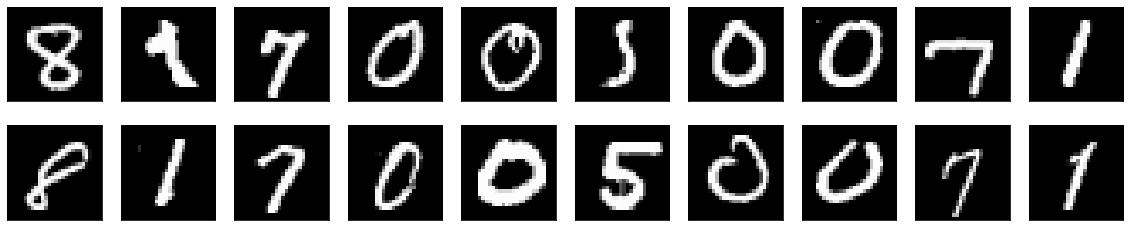

Classes: [8, 1, 7, 0, 0, 5, 0, 0, 7, 1]


In [30]:
pyplot.figure(figsize=(20, 4))
plotted_classes = []
for i in range(10):
    j = np.random.randint(0, len(data))
    ax = pyplot.subplot(2, 10, i + 1)
    pyplot.imshow(data[j].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = pyplot.subplot(2, 10, i + 1 + 10)
    pyplot.imshow(data_sim[j].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plotted_classes.append(data_classes[j])
pyplot.show()
print('Classes:', plotted_classes)

Podemos ver que efectivamente el dato asociado a cada imagen del conjunto x resulta similar. Como la selección de similaridad se realizó solo en base a la etiqueta, resulta que ambas imágenes tienen el mismo número (la misma etiqueta), pero pueden ser de "estilos" totalmente diferentes. En la última línea de imprimió la etiqueta asociada a las imágenes, verificando que el número corresponde a la etiqueta.

In [31]:
print('Forma de data:', data.shape)
print('Forma de data_sim:', data_sim.shape)
print('Largo de data_classes:', len(data_classes))

Forma de data: (20000, 28, 28, 1)
Forma de data_sim: (20000, 28, 28, 1)
Largo de data_classes: 20000


Podemos ver entonces que se generó un conjunto total de 20 mil imágenes asociadas con un similar asociado, cada imágen de tamaño $28 \times 28 = 784$.

> b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

Separemos el conjunto en datos de entrenamiento, validación y pruebas:

In [32]:
x_train_ori, x_test_ori, x_train_sim, x_test_sim, y_train_classes, y_test_classes = model_selection.train_test_split(
    data, data_sim, np.array(data_classes), test_size=0.15)
x_train_ori, x_val_ori, x_train_sim, x_val_sim, y_train_classes, y_val_classes = model_selection.train_test_split(
    x_train_ori, x_train_sim, y_train_classes, test_size=0.17645)
print('Forma de x_train_ori:', x_train_ori.shape)
print('Forma de x_val_ori:', x_val_ori.shape)
print('Forma de x_test_ori:', x_test_ori.shape)
print('Forma de x_train_sim:', x_train_sim.shape)
print('Forma de x_val_sim:', x_val_sim.shape)
print('Forma de x_test_sim:', x_test_sim.shape)
print('Forma de y_train_classes:', y_train_classes.shape)
print('Forma de y_val_classes:', y_val_classes.shape)
print('Forma de y_test_classes:', y_test_classes.shape)

Forma de x_train_ori: (14000, 28, 28, 1)
Forma de x_val_ori: (3000, 28, 28, 1)
Forma de x_test_ori: (3000, 28, 28, 1)
Forma de x_train_sim: (14000, 28, 28, 1)
Forma de x_val_sim: (3000, 28, 28, 1)
Forma de x_test_sim: (3000, 28, 28, 1)
Forma de y_train_classes: (14000,)
Forma de y_val_classes: (3000,)
Forma de y_test_classes: (3000,)


Tenemos entonces pares de conjuntos de entrenamiento con 14 mil imágenes, pares de validación de 3 mil imágenes, y de pruebas de 3 mil también.

De manera de utilizar una arquitectura que ha resultado exitosa hasta ahora, usaremos un autoencoder convolucional con dos capas ocultas.

Autoencoder dim 16 hidden layers 2 hidden num 32 convolutional True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampl

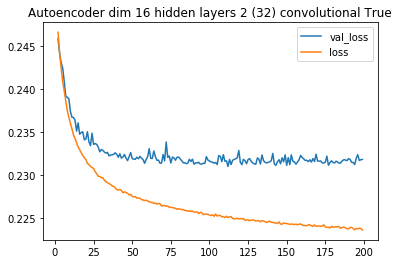

Error train: 0.2236377832548959 Error val: 0.23182994862397513


In [33]:
hist = build_model(x_train_ori, x_val_ori,
                   16, hidden_layers=2, hidden_num=32,
                   optimizer=optimizers.Adam(),
                   encoder_activation=activations.relu,
                   extra_x_train=x_train_sim, extra_x_val=x_val_sim)

Vemos que el error de reconstrucción resulta mucho mayor en este caso, además de resultar sobreajustado (aunque el error de validación no crece, ya no sigue bajando). Tiene sentido, ya que estamos intentando reconstruir una imagen diferente para cada imagen de la entrada. Incluso, algunas imágenes podrían estar repetidas con distintos "similares". Si bien el error de reconstrucción es mucho más alto, debería permitirnos clasificar mejor, ya que diferentes versiones del mismo dígito podrían quedar codificadas de manera parecida en el espacio latente. Veremos eso a continuación.

> c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

Codificación tamaño 16


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


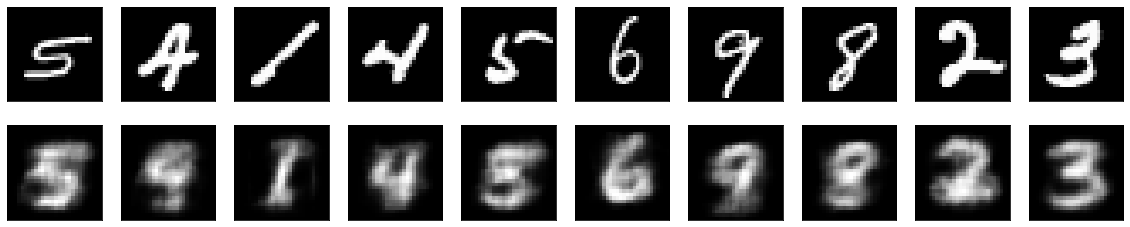

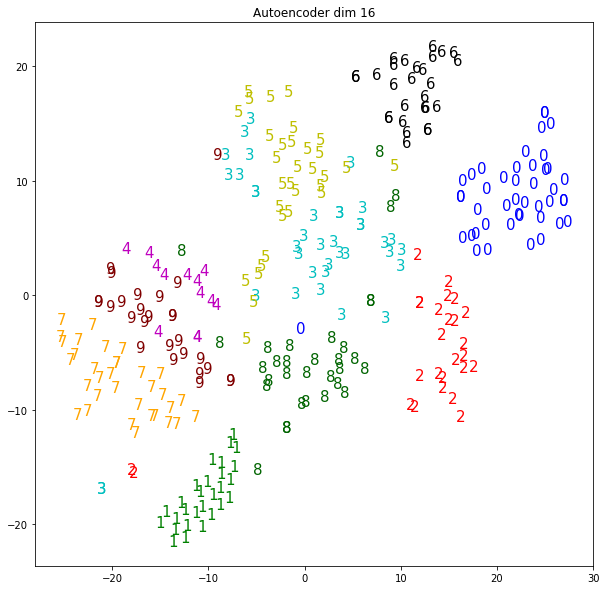

Classification Accuracy dim 16 PCA 0.99


/home/cserpell/.conda/envs/c3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Classification Accuracy Autoencoder dim 16 0.99


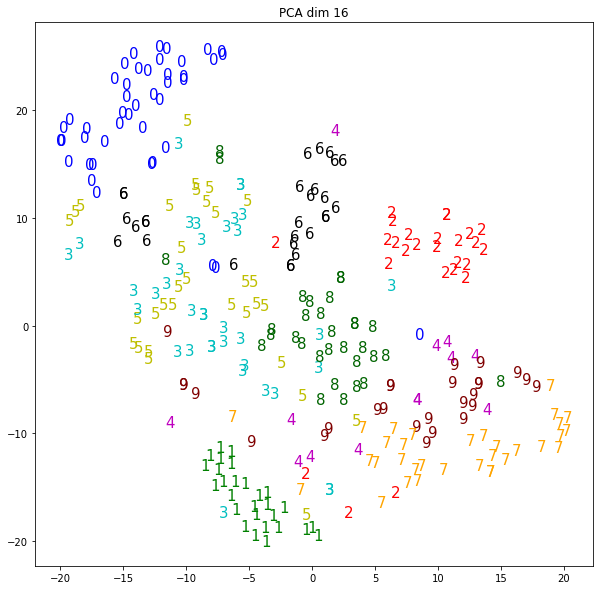

In [34]:
visualize_encoder(x_test_ori, 16, hidden_layers=2, hidden_num=32,
                  encoder_activation=activations.relu)
pca_score, ae_score = qualitative_compare(
    x_train_ori, y_train_classes, x_test_ori, y_test_classes,
    16, hidden_layers=2, hidden_num=32,
    encoder_activation=activations.relu, include_mini_ae=False)

En la inspección visual, vemos que efectivamente la reconstrucción es mucho más difusa que en los casos anteriores. La salida del autoencoder ya no es similar a la imagen original, pero sí a una versión "suavizada" del dígito. Cuando vemos la visualización usando t-SNE, vemos que efectivamente la proyección en el espacio latente hizo que los distintos dígitos quedasen mucho más apretados entre sí. Es decir, el autoencoder codifica cada dígito mucho más cerca a una especie de *promedio* de todas las versiones de él. Esto hace que el score de clasificación sea mucho mayor que en todos los casos anteriores, 0.99, y también superior a usar PCA.

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

> a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**

Para construir un modelo de clasificación, usamos etiquetas como vectores one hot y usamos la métrica de categorical crossentropy.

In [35]:
y_train_cat = utils.to_categorical(y_train, 10)
y_val_cat = utils.to_categorical(y_val, 10)
y_test_cat = utils.to_categorical(y_test, 10)

num_epochs2 = 50

def feedforward_model(activation):
    model = models.Sequential()
    model.add(layers.Dense(1000, activation=activation, input_shape=(784,)))
    model.add(layers.Dense(1000, activation=activation))
    model.add(layers.Dense(10, activation=activations.softmax))
    model.summary()
    optimizer = optimizers.SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])
    hist = model.fit(x_train1, y_train_cat, epochs=num_epochs2, batch_size=25,
                     shuffle=True, validation_data=(x_val1, y_val_cat),
                     verbose=0)
    _ = pd.DataFrame(hist.history).iloc[2:, :].plot(
    title='Clasificador feedforward')
    pyplot.show()
    print('Error de entrenamiento:', hist.history['loss'][-1])
    print('Error de validación:', hist.history['val_loss'][-1])
    print('Error test:', model.evaluate(x_test1, y_test_cat)[0])
    model.save('ReluNet-768x1000x1000x10-NFT-50epochs{}.h5'.format(
        activation.__name__))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_102 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_103 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


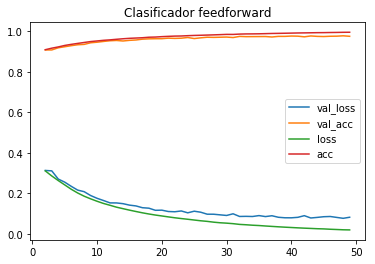

Error de entrenamiento: 0.019625980595817303
Error de validación: 0.08211173744522966
10000/10000 [==============================] - 1s 100us/step
Error test: 0.0751748391577974


In [36]:
feedforward_model(activations.sigmoid)

Vemos entonces que el modelo comenzó a sobreajustar levemente a partir de unos 25 epochs. El fin del entrenamiento con los 50 epochs usados fue con error de entrenamiento de 0,019 y de validación de 0,078. Finalmente, cuando medimos en el conjunto de prueba, se obtuvo un 0,076. Veremos a continuación cómo se comporta un modelo donde cada capa se preentrena como un autoencoder.

> b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.

Para el entrenamiento de los autoencoders intermedios, utilizamos la misma cantidad de epochs que en las partes anteriores de la tarea, y para el entrenamiento final, 50 epochs. En este caso usamos una función sigmoidal en las capas intermedias, y también en la activación del autoencoder.

In [37]:
batch_size = 32
## Load and preprocess MNIST as usual

def pre_trained_autoencoder(activation):
    optimizer = optimizers.SGD(lr=0.01, momentum=0.9)
    ### AUTOENCODER 1
    input_img1 = layers.Input(shape=(784,))
    encoded1 = layers.Dense(1000, activation=activation)(input_img1)
    decoded1 = layers.Dense(784, activation=activations.sigmoid)(encoded1)
    autoencoder1 = models.Model(inputs=input_img1, outputs=decoded1)
    encoder1 = models.Model(inputs=input_img1, outputs=encoded1)
    autoencoder1.compile(optimizer=optimizer, loss=losses.binary_crossentropy)
    autoencoder1.fit(x_train1, x_train1, epochs=num_epochs,
                     batch_size=batch_size, verbose=0,
                     shuffle=True, validation_data=(x_val1, x_val1))
    encoded_input1 = layers.Input(shape=(1000,))
    autoencoder1.save('autoencoder_layer1.h5')
    encoder1.save('encoder_layer1.h5')
    ### AUTOENCODER 2
    # FORWARD PASS DATA THROUGH FIRST ENCODER
    x_train_encoded1 = encoder1.predict(x_train1)
    x_val_encoded1 = encoder1.predict(x_val1)
    x_test_encoded1 = encoder1.predict(x_test1)
    input_img2 = layers.Input(shape=(1000,))
    encoded2 = layers.Dense(1000, activation=activation)(input_img2)
    decoded2 = layers.Dense(1000, activation=activation)(encoded2)
    autoencoder2 = models.Model(inputs=input_img2, outputs=decoded2)
    encoder2 = models.Model(inputs=input_img2, outputs=encoded2)
    autoencoder2.compile(optimizer=optimizer, loss=losses.binary_crossentropy)
    autoencoder2.fit(x_train_encoded1, x_train_encoded1, epochs=num_epochs,
                     batch_size=batch_size, shuffle=True, verbose=0,
                     validation_data=(x_val_encoded1, x_val_encoded1))
    encoded_input2 = layers.Input(shape=(1000,))
    autoencoder2.save('autoencoder_layer2.h5')
    encoder2.save('encoder_layer2.h5')
    # FINE TUNNING
    model = models.Sequential()
    model.add(layers.Dense(1000, activation=activation,
                           input_shape=(784,)))
    model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
    model.add(layers.Dense(1000, activation=activation))
    model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
    model.add(layers.Dense(10, activation=activations.softmax))
    model.summary()
    model.compile(optimizer=optimizer, loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])
    hist = model.fit(x_train1, y_train_cat, epochs=num_epochs2, batch_size=25,
                     shuffle=True, validation_data=(x_val1, y_val_cat),
                     verbose=0)
    _ = pd.DataFrame(hist.history).iloc[2:, :].plot(
    title='Clasificador feedforward con preentrenamiento')
    pyplot.show()
    print('Error de entrenamiento:', hist.history['loss'][-1])
    print('Error de validación:', hist.history['val_loss'][-1])
    print('Error test:', model.evaluate(x_test1, y_test_cat)[0])
    model.save('Net-768x1000x1000x10-finetunned.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_109 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_110 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


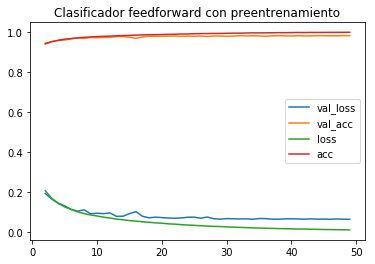

Error de entrenamiento: 0.009349983079657911
Error de validación: 0.06247361059911782
10000/10000 [==============================] - 1s 102us/step
Error test: 0.05729388325618929


In [38]:
pre_trained_autoencoder(activations.sigmoid)

Vemos que el uso del preentrenamiento efectivamente mejoró bastante los errores de generalización (validación de 0.078 a 0.055, test de 0.076 a 0.056), aunque también el de entrenamiento (de 0.019 a 0.010). Esto puede deberse a que cada capa se entrenó usando una cantidad grande de epochs que permite ajustarla muy bien a la distribución de los datos, y luego el clasificador final tan se dedica mayormente a mejorar la última capa dedicada a la clasificación.

> c) Repita usando funciones de **activación *tanh*. Comente**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_112 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_113 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


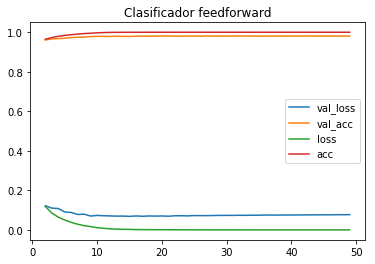

Error de entrenamiento: 0.0003319868454712414
Error de validación: 0.07748332704952646
10000/10000 [==============================] - 1s 101us/step
Error test: 0.0641871772129588


In [39]:
feedforward_model(activations.tanh)

Al usar función de activación en capas intermedias `tanh`, vemos que la red básica de clasificación mejora su desempeño, aunque con un sobreajuste aun más pronunciado. Esto tal vez puede deberse a que el uso de `tanh` permite que la salida de las capas intermedias sea más cercana a 0 en promedio, en vez de $\frac{1}{2}$, permitiendo a la siguiente capa tener entradas más centradas.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 1000)              785000    
_________________________________________________________________
dense_119 (Dense)            (None, 1000)              1001000   
_________________________________________________________________
dense_120 (Dense)            (None, 10)                10010     
Total params: 1,796,010
Trainable params: 1,796,010
Non-trainable params: 0
_________________________________________________________________


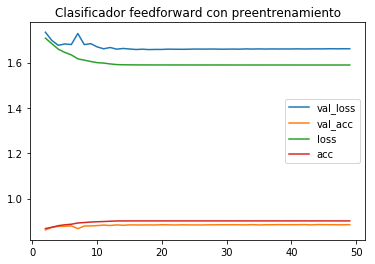

Error de entrenamiento: 1.5894345321319896
Error de validación: 1.6610171018116306
10000/10000 [==============================] - 1s 115us/step
Error test: 1.6054158150524904


In [40]:
pre_trained_autoencoder(activations.tanh)

Vemos finalmente que el uso de la red entrenada con autoencoders, presenta una mejora leve con respecto a la tradicional usando `tanh`. En este caso la mejora es mucho más pequeña que en el caso de la función de activación sigmoidal. Por otro lado, la red preentrenada usando función de activación sigmoidal presentó un mejor error de generalización (más pequeño), que usando función `tanh`. Esto podría deberse a que la función sigmoidal efectivamente reconstruye una imagen entre 0 y 1, permitiendo un mejor preentenamiento. En la siguiente tabla vemos todos los resultados con las cuatro configuraciones, permitiendo comparar.

|  -  | Feedforward sigmoidal | Feedforward `tanh` | Preentrenada sigmoidal | Preentrenada `tanh` |
|:---:|:---:|:---:|:---:|:---:|
| Entrenamiento | 0,019 | 0.001 | 0.010 | 0.001 |
| Validación | 0.078 | 0.064 | **0.055** | 0.063 |
| Pruebas | 0.076 | 0.068 | **0.056** | 0.064 |

Finalmente, concluimos esta parte de la tarea indicando los mayores aprendizajes:

- El uso de función de activación ReLU en la capa de codificación del autoencoder mejora la reconstrucción, apagando características y funcionando como una selección de características.
- El uso de capas ocultas y convoluciones mejora la representación obtenida por autoencoders, en el caso de imágenes.
- La representación en dimensionalidad reducida lograda por autoencoders logra mejorar el desempeño en la clasificación, manteniendo el tiempo de cómputo, en comparación con PCA para la misma cantidad de dimensiones.
- El autoencoder logra reconstruir las imágenes en el caso en que se agrega ruido a éstas.
- El preentrenamiento de una red usando autoencoders puede ayudar a problemas de clasificación, siempre y cuando sean usadas las funciones de activación correctas.

<a id="refs"></a>
## Referencias
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.